In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import itertools as itertools
from matplotlib.animation import FuncAnimation,FFMpegFileWriter
from tqdm import tqdm

# Used Functions 

## 1D Algorithms

In [2]:
#############################
# Euler Scheme
def euler(ro, V, h, sigma=0):
    n = ro.shape[0]
    if (ro.shape[0] == ro.size):
        ro = ro + h * V(ro) + sigma * 2 * np.sqrt(h) * np.random.standard_normal(np.array(ro.shape))
    else:
        for i in range(n):
            ro[i] = ro[i] + h * V(ro[i]) + sigma * 2 * np.sqrt(h) * rand.standard_normal(np.array(ro[i].shape))
    return ro

#############################
#Information matrix calculation(and its inverse)
def Mro(ro,f):
    # ro = matrices de forme (n,d) contenant les coordonnées des n particules qui donne la mesure empirique
    # f fonction donnée par le problème
    # M matrice d'information
    n = ro.shape[0]
    M = (f(ro).T).dot(f(ro)) / n
    invM = np.linalg.inv(M)
    return np.linalg.det(M), invM

#############################
#Velocity field
def Vt (f , df, invM):
    def Vt(x):
        n = x.shape[0]
        vec = 2*np.sum((df(x).T).dot(invM) * f(x), axis=1) / n
        return vec
    return Vt

#############################
# V expectation (V used for Birth-Death sampling)
def Vexp(ro0, invM, f, sigma): ## Calcul de la moyenne de V
    n = ro0.shape[0] 
    Vbar = 0
    for i in range(n):
        Vbar = Vbar - f(ro0[i]).dot(invM).dot(f(ro0[i]).T) #+ sigma *(np.log(ro0[i]) +1)
    return Vbar / n

############################
# Gradient flow algorithm 
# Put non-zero function for sigma to have Langevin Dynamic
# Put non-zero function for alpha to have Birth-Death Dynamic
def flow(ro0, f, df, h, nt,mini = 0, maxi =1, sigma = lambda x :0, alpha = lambda x : 0):
    ro = ro0
    n = ro.shape[0]
    shape = ro.shape
    val_list = []
    if (alpha(0) == 0):
        for i in tqdm(range(nt)):
            val, invM = Mro(ro,f)
            V = Vt(f, df, invM)
            ro = euler(ro, V, h, sigma(i))
            ro = np.reshape(np.clip( ro.flatten(), mini, maxi), shape)
            val_list.append(val)
    else:  
        ####
        # Partie à regardé. Algorithme 1 Dans Bruna, Page 10, 
        # V = -f(x) M(\mu)^{-1} f(x)^t 
        # Vtilde = V - Vexp
        # f(x) = (x, x**2, x**3)
        ####
        for i in tqdm(range(nt)):
            val, invM = Mro(ro,f)
            V = Vt(f, df, invM)
            ro = euler(ro, V, h, sigma(i))
            ro = np.reshape(np.clip( ro.flatten(), mini, maxi), shape)
            Vbar = -Vexp(ro, invM, f, sigma)
            # Debut Birth-Death
            j =0
            ro1 = []
            while (j < ro.shape[0]):
                Vtilde =  f(ro[j]).dot(invM).dot(f(ro[j]).T) -(Vbar) #+ sigma * (np.log(ro[i]) + 1 ) -Vbar
                if ((Vtilde<0)and(rand.uniform()<1-np.exp(alpha(i)*Vtilde*h))): #Death
                    j = j+1
                elif ((Vtilde>0) and (rand.uniform()<1 - np.exp(-alpha(i)*Vtilde*h))): # Birth
                    ro1.append(ro[j])
                    ro1.append(ro[j])
                    j=j+1
                else: 
                    ro1.append(ro[j])
                    j= j+1
            ro = np.array(ro1)
            n1 = ro.shape[0]
            if (n1>n): #Boucle pour garder un nombre de particule constant
                for i in range(n1-n):
                    k = np.floor(rand.uniform()*ro.shape[0])
                    ro = np.delete(ro,k)
            if (n1<n):
                for i in range(n-n1):
                    k = np.int(np.floor(rand.uniform()*ro.shape[0]))
                    ro = np.append(ro, ro[k])
            # Fin Birth-Death
            val_list.append(val)
    return ro, val_list

###########################
# Overparametrization: We add weights to the particle and maximize over weights
# Sigma not interesting
def overparam(ro, f, niter, h, sigmaW = lambda x: 0, ponderation = False):
    n = ro.size
    w = 0*ro +1/ro.size 
    val_list=[]
    for i in range(niter):
        M = f(ro).T.dot(w[:, np.newaxis] * f(ro))
        invM = np.linalg.inv(M)
        offset = 0
        for j in range (n):
            xi = f(ro)[j][np.newaxis,:]
            offset = offset + (xi).dot(invM).dot(xi.T)[0,0]
            w[j] = w[j] + h * (xi).dot(invM).dot(xi.T) + sigmaW(i) * 2 * np.sqrt(h) * rand.normal()
        if (ponderation):
            w = w/np.sum(w)
        else:
            w = w - h*offset/n
        val_list.append(np.linalg.det(M))
    return w, val_list


## N-D Algorithm

In [3]:
#################################
# Euler for multidimensional models
def eulerprim(ro, V, h, sigma = 0):
    n = ro.shape[0]
    ro = ro + h * V(ro) + sigma * 2 * np.sqrt(h) * np.random.standard_normal(np.array(ro.shape))
    return ro

#################################
# Information matrix multi-D
def Mromultiprim(ro, g):
    n = ro.shape[0]
    M = g(ro).T.dot(g(ro))
    M = M/n
    invM = np.linalg.inv(M)
    return np.linalg.det(M), invM
    
#################################
# Velocity field multi-D
def Vtmultiprim(g, dg, invM):
    def Vt(x):
        vec = 2* np.asarray([el.dot(v) for (el,v) in zip (dg(x).dot(invM),g(x))])
        return vec
    return Vt

#################################
# V expectation, Used for Birth Death
def Vexpmulti(ro0, invM, f, sigma): ## Calcul de la moyenne de V
    n = ro0.shape[0] 
    Vbar = 0
    for i in range(n):
        Vbar = Vbar - f(np.array([ro0[i]])).dot(invM).dot(f(np.array([ro0[i]])).T) #+ sigma *(np.log(ro0[i]) +1)
    return Vbar / n

#################################
# Gradient flow algorithm
# Sigma for Langevin 
# Alpha for birth-Death
def flowmultiprim(ro0, f, df, h, nt,mini = 0, maxi =1, sigma = lambda x: 0, alpha = lambda x :0):
    ro = ro0
    n = ro.shape[0]
    shape = ro.shape
    val_list = []
    image =[]
    Vbar =  f(np.array([ro[0]])).size
    if (alpha(0) == 0):
        for i in tqdm(range(nt)):
            val, invM = Mromultiprim(ro,f)
            V = Vtmultiprim(f, df, invM)
            ro = eulerprim(ro, V, h, sigma(i))
            ro = np.reshape(np.clip( ro.flatten(), mini, maxi), shape)
            val_list.append(val)
            image.append(ro)
    else:  
        for i in tqdm(range(nt)):
            val, invM = Mromultiprim(ro,f)
            V = Vtmultiprim(f, df, invM)
            ro = eulerprim(ro, V, h, sigma(i))
            ro = np.reshape(np.clip( ro.flatten(), mini, maxi), shape)
            
            # Debut Birth-Death
            j =0
            ro1 = []
            while (j < ro.shape[0]):
                Vtilde =  f(np.array([ro[j]])).dot(invM).dot(f(np.array([ro[j]])).T) -(Vbar) #+ sigma * (np.log(ro[i]) + 1 ) -Vbar
                if ((Vtilde<0)and(rand.uniform()<1-np.exp(alpha(i)*Vtilde*h))): #Death
                    j = j+1
                elif ((Vtilde>0) and (rand.uniform()<1 - np.exp(-alpha(i)*Vtilde*h))): # Birth
                    ro1.append(ro[j])
                    ro1.append(ro[j])
                    j=j+1
                else: 
                    ro1.append(ro[j])
                    j= j+1
            ro = np.array(ro1)
            n1 = ro.shape[0]
            if (n1>n): #Boucle pour garder un nombre de particule constant
                for i in range(n1-n):
                    k = np.int(np.floor(rand.uniform()*ro.shape[0]))
                    ro = np.delete(ro,k,0)
            if (n1<n):
                for i in range(n-n1):
                    k = np.int(np.floor(rand.uniform()*ro.shape[0]))
                    ro = np.append(ro, np.array([ro[k]]),0)
            # Fin Birth-Death
            image.append(ro)
            val_list.append(val)
    return ro, val_list, image

###################################
# Over-parametrization Multi-D
def overparammultiprim(ro, f, niter, h, sigmaw = lambda x: 0, ponderation = False):
    n = ro.shape[0]
    w = np.zeros(n)+1/n
    val_list=[]
    roprim = ro
    for i in range(niter):
        n = roprim.shape[0]
        M = f(roprim).T.dot(w[:, np.newaxis] * f(roprim))
        invM = np.linalg.inv(M)
        offset = 0
        for j in range (n):
            if (w[j] != 0):
                xi = f(roprim)[j][np.newaxis,:]
                offset = offset + (xi).dot(invM).dot(xi.T)[0,0]
                w[j] = w[j] + h * (xi).dot(invM).dot(xi.T) + sigmaw(i) * 2 * np.sqrt(h) * rand.normal()
        
        if (ponderation):
            w = w/np.sum(w)
        else:
            w = w -h*offset/n
            w = w*(w>0)
            j = 0
            while (j<w.size):
                if (w[j]==0):
                    w= np.delete(w, j)
                    roprim = np.delete(roprim, j,0)
                else:
                    j = j+1
            w = w/np.sum(w)
        val_list.append(np.linalg.det(M))
    return w, val_list, roprim




# 1D testing

## Cubic regression from the origin

In [4]:
## model function f
f = lambda x : np.array([x, x**2, x**3]).T
## It's Gradient
df = lambda x : np.array([x*0+1, 2*x, 3*x**2])

In [5]:
##ro_star is the D_optimal measure for this model
mu_star = np.array([(5 - np.sqrt(5))/10, (5 + np.sqrt(5))/10, 1])
mu_star = mu_star[:]
opt = Mro(mu_star, f)[0]

## Standard Algorithm

In [223]:
np.random.seed(0)
nt = 10000
h= 0.01
ro = rand.rand(101)
sigma = lambda x: 0
alpha = lambda x: 0
rofstd, val_liststd = flow(ro, f, df, h, nt, sigma=sigma, alpha=alpha)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9327.10it/s]


In [224]:
(val_liststd[-1] /opt)**(1/3)

0.8965017099955886

On obtient $\big\{\frac{Det M(\mu)}{Det M(\mu_\star)}\big\}^{\frac{1}{3}} = 0.89$

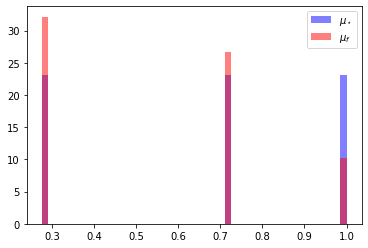

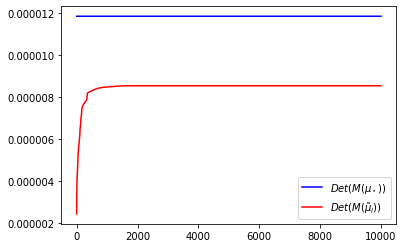

In [225]:
plt.hist(mu_star, bins = 50, density=True, Alpha = 0.5, label =r"$\mu_\star$", color ="blue")
plt.hist(rofstd, bins = 50, density=True, Alpha = 0.5, label =r"$\mu_f$", color ="red")
plt.legend()
plt.show()
plt.plot(np.arange(nt), (opt + 0 * np.arange(nt)), label = r"$Det(M(\mu_\star))$", color ="blue")
plt.plot(np.arange(nt), (val_liststd), label= r"$Det(M(\tilde{\mu}_i))$", color="red")
plt.legend()
plt.show()

### Very loose criterion 
The criterion we will be using is very loose as shown next:
$$\big\{\frac{Det M(\mu)}{Det M(\mu_\star)}\big\}^{\frac{1}{p}} \geq exp(-\frac{\bar {d}(\mu) - p}{p})$$
the criterion gives a D-efficiency of $0.28$ when the true D-efficiency is $0.896$ which is way higher.
This calls for using the other inequality we have:
$$\big\{\frac{Det M(\mu)}{Det M(\mu_\star)}\big\}^{\frac{1}{p}} \leq \frac{1} { \bigg(\frac{\bar{d}(\mu)}{p}\bigg) \bigg(\frac{p-1}{\bar{d}(\mu)-1}\bigg)^{1-1/p}}$$
Which gives $0.899$ which is very close. 

Understand from this we should keep some skepticism when using these criteria, since the gap between them can be very wide.

0.28810091974552415
0.8991026361483204


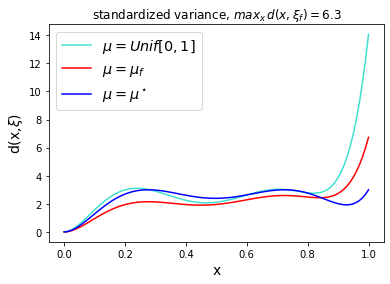

In [227]:
ro = np.linspace(0,1,101)
p = 3
Mf,invMf = Mro(ro, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\mu = Unif[0,1]$", color = "turquoise")

Mf,invMf = Mro(rofstd, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\mu = \mu_f$", color = "red")
print(np.exp(-(dfopt[-1]-p)/p))
print(1/((dfopt[-1]/p) * ((p-1)/(dfopt[-1]-1))**(1-1/p)) )

Mf,invMf = Mro(mu_star, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\mu = \mu^\star$", color="blue")
plt.xlabel ('x', fontsize = 14)
plt.ylabel (r'd(x,$\xi$)',fontsize = 14)
plt.legend(fontsize ='x-large')

plt.title (r'standardized variance, $max_x\, d(x,\mu_f) = 6.3$')
plt.show()

## Noisy algorithm

The idea behind this is the observation that particles get stuck in local maximas of $d(x,\mu)$.
We think of adding noise to each particle so that, hopefully, we can compensate for the disparity we find by giving the particles a chance of moving from a caption area to another. It is called in the literature Langevin dynamic.


### Influence of the variace of the added noisy

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:02<00:00, 9465.73it/s]


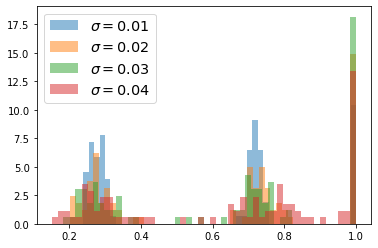

In [248]:
np.random.seed(0)
nt = 20000
h= 0.01
sigma1 = lambda x : 0.01
alpha = lambda x : 0 
ro = np.linspace(0,1,101)
rofsig1, val_listsig1 = flow(ro, f, df, h, nt, sigma=sigma1, alpha=alpha)
plt.hist(rofsig1, bins=50, density=True, alpha = 0.5, label = r"$\sigma =0.01$") 

nt = 20000
h= 0.01
sigma2 = lambda x : 0.02
alpha = lambda x : 0
ro = np.linspace(0,1,101)
rofsig2, val_listsig2 = flow(ro, f, df, h, nt, sigma=sigma2, alpha=alpha)
plt.hist(rofsig2, bins=50, density=True, alpha = 0.5, label = r"$\sigma =0.02$") 

nt = 20000
h= 0.01
sigma3 = lambda x : 0.03
alpha = lambda x : 0
ro = np.linspace(0,1,101)
rofsig3, val_listsig3 = flow(ro, f, df, h, nt, sigma=sigma, alpha=alpha)
plt.hist(rofsig3, bins=50, density=True, alpha = 0.5, label = r"$\sigma =0.03$") 

nt = 20000
h= 0.01
sigma4 = lambda x :0.04
alpha = lambda x : 0
ro = np.linspace(0,1,101)
rofsig4, val_listsig4 = flow(ro, f, df, h, nt, sigma=sigma4, alpha=alpha)
plt.hist(rofsig4, bins=50, density=True, alpha = 0.5, label = r"$\sigma =0.04$") 
plt.legend(fontsize ='x-large')

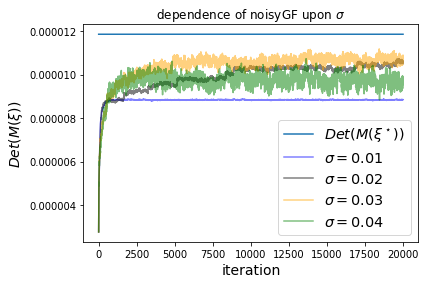

In [249]:
plt.plot(np.arange(nt), (opt + 0 * np.arange(nt)), label = r"$Det(M(\xi^\star))$")
plt.plot(np.arange(nt), (val_listsig1), alpha =0.5,label= r"$\sigma =0.01$",color='blue')
plt.plot(np.arange(nt), (val_listsig2), alpha =0.5,label= r"$\sigma =0.02$",color='black')
plt.plot(np.arange(nt), (val_listsig3), alpha =0.5,label= r"$\sigma =0.03$",color='orange')
plt.plot(np.arange(nt), (val_listsig4), alpha =0.5,label= r"$\sigma =0.04$",color='green')
plt.legend(fontsize="x-large")
plt.xlabel("iteration",fontsize =14)
plt.ylabel(r"$Det(M(\xi))$", fontsize=14)
plt.title(r"dependence of noisyGF upon $\sigma$")
plt.show()

### The case $\sigma = 0.02$

In [254]:
np.random.seed(0)
nt = 20000
h= 0.01
ro = np.linspace(0,1,101)
sigma = lambda x: 0.03
alpha = lambda x: 0
rofstd, val_liststd = flow(ro, f, df, h, nt, sigma=lambda x:0, alpha=alpha)
rofnoisy, val_listnoisy = flow(ro, f, df, h, nt, sigma=sigma, alpha=alpha)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:02<00:00, 9249.61it/s]


In [255]:
(val_listnoisy[-1] /opt)**(1/3)

0.9577525631684198

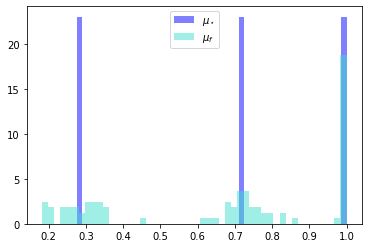

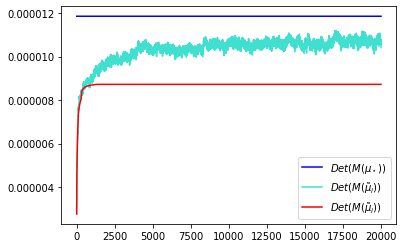

In [256]:
plt.hist(mu_star, bins = 50, density=True, Alpha = 0.5, label =r"$\mu_\star$", color ="blue")
plt.hist(rofnoisy, bins = 50, density=True, Alpha = 0.5, label =r"$\mu_f$", color ="turquoise")
plt.legend()
plt.show()
plt.plot(np.arange(nt), (opt + 0 * np.arange(nt)), label = r"$Det(M(\mu_\star))$", color ="blue")
plt.plot(np.arange(nt), (val_listnoisy), label= r"$Det(M(\tilde{\mu}_i))$", color="turquoise")
plt.plot(np.arange(nt), (val_liststd), label= r"$Det(M(\tilde{\mu}_i))$", color="red")
plt.legend()
plt.show()

Dans cette situation, l'estimation de la D-efficiency est bien meilleur que dans la premiere situation

lower bound = 0.914996817804058
higher bound = 0.9982877060227372


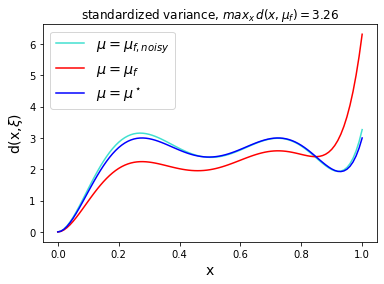

In [261]:
ro = np.linspace(0,1,101)
p = 3
Mf,invMf = Mro(rofnoisy, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\mu = \mu_{f,noisy}$", color = "turquoise")
print("lower bound = "+ str(np.exp(-(dfopt[-1]-p)/p)))
print("higher bound = " +str(1/((dfopt[-1]/p) * ((p-1)/(dfopt[-1]-1))**(1-1/p)) ))

Mf,invMf = Mro(rofstd, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\mu = \mu_f$", color = "red")

Mf,invMf = Mro(mu_star, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\mu = \mu^\star$", color="blue")
plt.xlabel ('x', fontsize = 14)
plt.ylabel (r'd(x,$\xi$)',fontsize = 14)
plt.legend(fontsize ='x-large')

plt.title (r'standardized variance, $max_x\, d(x,\mu_f) = 3.26$')
plt.show()

## Simulated annealing

### Decreasing Too slow

In [290]:
np.random.seed(0)
nt = 500000
h= 0.01
sigma = lambda x : 0.5/np.log(x+10) # mettre sigma à 0 pour ne pas ajouter d'entropie
alpha = lambda x : 0
ro = np.linspace(0,1,101)
M, invM = Mro(ro,f)
rofSAGFlog, val_listSAGFlog = flow(ro, f, df, h, nt, sigma=sigma, alpha=alpha)
rofstd, val_liststd = flow(ro, f, df, h, nt, sigma=lambda x: 0, alpha=alpha)

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [00:53<00:00, 9421.15it/s]


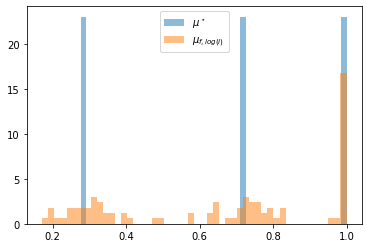

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


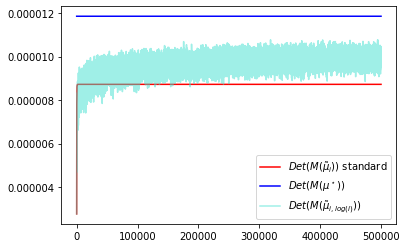

In [291]:
plt.hist(ro_star, bins=50, density=True, alpha = 0.5, label = r"$\mu^\star$") 
#plt.hist(rof, bins=50, density=True, alpha = 0.5, label = r"$\xi_f$") 
plt.hist(rofSAGFlog, bins=50, density=True, alpha = 0.5, label = r"$\mu_{f,log(i)}$ ") 
plt.legend()
plt.show()
plt.plot(np.arange(nt), (val_liststd),             label= r"$Det(M(\tilde{\mu}_i))$ standard",        color = "red")
plt.plot(np.arange(nt), (opt + 0 * np.arange(nt)), label = r"$Det(M(\mu^\star))$",           color = "blue")
plt.plot(np.arange(nt), (val_listSAGFlog),         label= r"$Det(M(\tilde{\mu}_{i,log(i)}))$ ", color = "turquoise", alpha =0.5)
plt.legend()
plt.show()

In [318]:
print ("D-efficiency =")
print((val_listSAGFlog[-1]/opt)**(1/3))

D-efficiency =
0.9397302038993636


### Decreasing Too Fast

In [296]:
np.random.seed(0)
nt = 20000
h= 0.01
sigma = lambda x : 0.5/np.sqrt(x+10) 
alpha = lambda x : 0
ro = np.linspace(0,1,101)
rofSAGFsqrt, val_listSAGFsqrt = flow(ro, f, df, h, nt, sigma=sigma, alpha=alpha)
rofstd, val_liststd = flow(ro, f, df, h, nt, sigma=lambda x: 0, alpha=alpha)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:02<00:00, 9524.81it/s]


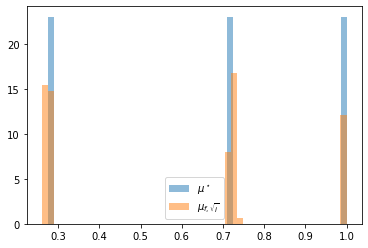

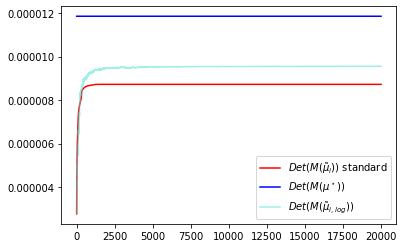

In [297]:
plt.hist(ro_star, bins=50, density=True, alpha = 0.5, label = r"$\mu^\star$") 
plt.hist(rofSAGFsqrt, bins=50, density=True, alpha = 0.5, label = r"$\mu_{f,\sqrt{i} }$ ") 
plt.legend()
plt.show()
plt.plot(np.arange(nt), (val_liststd),             label= r"$Det(M(\tilde{\mu}_i))$ standard",        color = "red")
plt.plot(np.arange(nt), (opt + 0 * np.arange(nt)), label = r"$Det(M(\mu^\star))$",           color = "blue")
plt.plot(np.arange(nt), (val_listSAGFsqrt),         label= r"$Det(M(\tilde{\mu}_{i,log}))$ ", color = "turquoise", alpha =0.5)
plt.legend()
plt.show()

D-efficiency =
0.9305611687413632
maximum of standardized variance = 
5.609913676205565
lower bound = 0.4189636045835537
higher bound = 0.9331259655221028


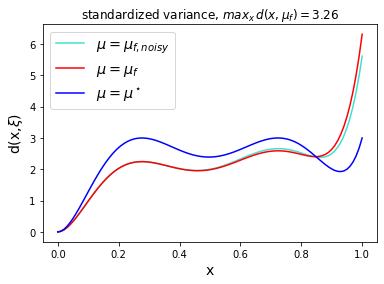

In [330]:
ro = np.linspace(0,1,101)
p = 3
Mf,invMf = Mro(rofSAGFsqrt, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\mu = \mu_{f,noisy}$", color = "turquoise")
print ("D-efficiency =")
print((val_listSAGFsqrt[-1]/opt)**(1/3))
print("maximum of standardized variance = ")
print(dfopt[-1])
print("lower bound = "+ str(np.exp(-(dfopt[-1]-p)/p)))
print("higher bound = " +str(1/((dfopt[-1]/p) * ((p-1)/(dfopt[-1]-1))**(1-1/p)) ))

Mf,invMf = Mro(rofstd, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\mu = \mu_f$", color = "red")

Mf,invMf = Mro(mu_star, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\mu = \mu^\star$", color="blue")
plt.xlabel ('x', fontsize = 14)
plt.ylabel (r'd(x,$\xi$)',fontsize = 14)
plt.legend(fontsize ='x-large')

plt.title (r'standardized variance, $max_x\, d(x,\mu_f) = 3.26$')
plt.show()

### Decreasing suitably

In [309]:
np.random.seed(0)
nt = 250000
h= 0.01
sigma = lambda x :0.5/np.cbrt(x+100) 
alpha = lambda x : 0
ro = np.linspace(0,1,101)
rofSAGFcbrt, val_listSAGFcbrt = flow(ro, f, df, h, nt, sigma=sigma, alpha=alpha)
rofstd, val_liststd = flow(ro, f, df, h, nt, sigma=lambda x : 0, alpha=alpha)

100%|████████████████████████████████████████████████████████████████████████| 250000/250000 [00:27<00:00, 9120.80it/s]


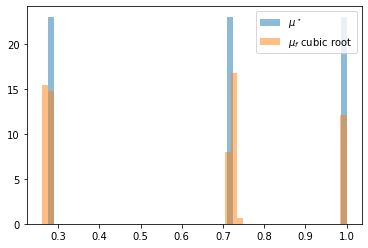

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


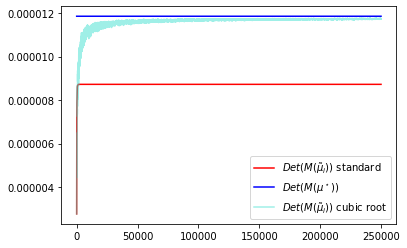

In [310]:
plt.hist(ro_star, bins=50, density=True, alpha = 0.5, label = r"$\mu^\star$") 
plt.hist(rofSAGFsqrt, bins=50, density=True, alpha = 0.5, label = r"$\mu_{f}$ cubic root ") 
plt.legend()
plt.show()

plt.plot(np.arange(nt), (val_liststd),             label= r"$Det(M(\tilde{\mu}_i))$ standard",        color = "red")
plt.plot(np.arange(nt), (opt + 0 * np.arange(nt)), label = r"$Det(M(\mu^\star))$",           color = "blue")
plt.plot(np.arange(nt), (val_listSAGFcbrt),         label= r"$Det(M(\tilde{\mu}_{i}))$ cubic root", color = "turquoise", alpha =0.5)
plt.legend()
plt.show()

D-efficiency =
0.9968054620378217
Maximum of standardized variance =
3.2565589132985906
lower bound = 0.918035114718198
higher bound = 0.9984050505588956


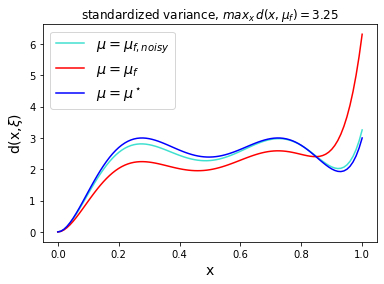

In [329]:
ro = np.linspace(0,1,101)
p = 3
Mf,invMf = Mro(rofSAGFcbrt, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\mu = \mu_{f,noisy}$", color = "turquoise")
print ("D-efficiency =")
print((val_listSAGFcbrt[-1]/opt)**(1/3))
print("Maximum of standardized variance =")
print(dfopt[-1])
print("lower bound = "+ str(np.exp(-(dfopt[-1]-p)/p)))
print("higher bound = " +str(1/((dfopt[-1]/p) * ((p-1)/(dfopt[-1]-1))**(1-1/p)) ))

Mf,invMf = Mro(rofstd, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\mu = \mu_f$", color = "red")

Mf,invMf = Mro(mu_star, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\mu = \mu^\star$", color="blue")
plt.xlabel ('x', fontsize = 14)
plt.ylabel (r'd(x,$\xi$)',fontsize = 14)
plt.legend(fontsize ='x-large')

plt.title (r'standardized variance, $max_x\, d(x,\mu_f) = 3.25$')
plt.show()


Once again, the criterion we have to test for convergence in case we don't know the determinant of the D-optimal design information matrix. We at least observe that the upper bound can be more relevant but we don't have any theoretical consideration in favor of using that.

## Over-parametrization

The idea begin this comes from the observation that standard GF algorithm actually gives the right positions but exhibit some disparities in the repartition of the particles between the 3 positions.
What comes naturally then is that we could add weights to the particules, which will be evenly distributed at first, then we will want to maximize our functional as a function of the weights $\omega_i$

In [234]:
np.random.seed(0)
nt = 4000
h= 0.01
ro = np.random.rand(101)
sigma = lambda x: 0
alpha = lambda x: 0
rofstd, val_liststd = flow(ro, f, df, h, nt, sigma=sigma, alpha=alpha)

#### Over-parametrization
hOP = 0.001
niter = 20
ponderation = False
sigmaW = lambda x : 0
W, val_listOP = overparam(rofstd, f, niter, hOP, sigmaW = sigmaW, ponderation = ponderation)

100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 9195.34it/s]


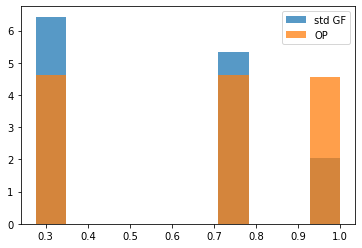

In [235]:
plt.hist(rofstd, bins=10, density=True,alpha =0.75, label= "std GF")
plt.hist(rofstd, bins=10, density=True, weights = W,alpha =0.75, label = "OP")
plt.legend()
plt.show()

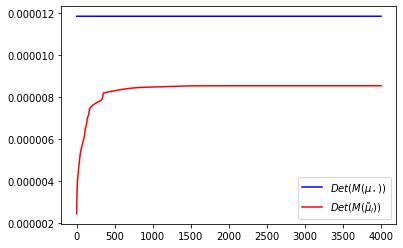

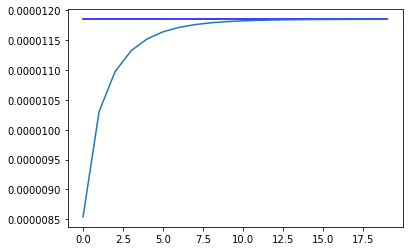

In [241]:
plt.plot(np.arange(nt), (opt + 0 * np.arange(nt)), label = r"$Det(M(\mu_\star))$", color ="blue")
plt.plot(np.arange(nt), (val_liststd), label= r"$Det(M(\tilde{\mu}_i))$", color="red")
plt.legend()
plt.show()

plt.plot(np.arange(niter), (opt + 0 * np.arange(niter)), label = r"$Det(M(\mu_\star))$", color ="blue")
plt.plot(np.arange(niter), val_listOP)
plt.show()

In [243]:
#### Over-parametrization
hOP = 0.001
niter = 100
ponderation = True
sigmaW = lambda x : 0
W, val_listOP = overparam(rofstd, f, niter, hOP, sigmaW = sigmaW, ponderation = ponderation)

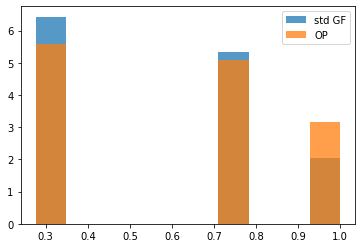

In [244]:
plt.hist(rofstd, bins=10, density=True,alpha =0.75, label= "std GF")
plt.hist(rofstd, bins=10, density=True, weights = W,alpha =0.75, label = "OP")
plt.legend()
plt.show()

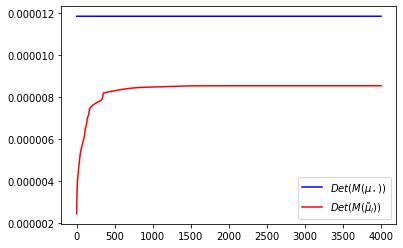

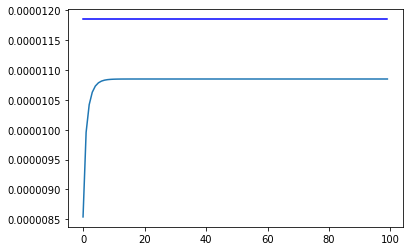

In [245]:
plt.plot(np.arange(nt), (opt + 0 * np.arange(nt)), label = r"$Det(M(\mu_\star))$", color ="blue")
plt.plot(np.arange(nt), (val_liststd), label= r"$Det(M(\tilde{\mu}_i))$", color="red")
plt.legend()
plt.show()

plt.plot(np.arange(niter), (opt + 0 * np.arange(niter)), label = r"$Det(M(\mu_\star))$", color ="blue")
plt.plot(np.arange(niter), val_listOP)
plt.show()

We see that if we consider a derivative that has zero mean, over-parametrization works, but not when we are normalizing each time. That is because when choosing normalization, since the distribution of particles stays constant, the equilibrium point is reached when the added weight to each particle each time is compensated by the normalization(lesser numbered particles at 1 get more weight each time but th, whereas when using the natural approach, equilibrium is reached when each particle gets the same weight addition, which is nullified by the normalization.(TO BE REVISED)

## Birth-Death dynamic

In [58]:
np.random.seed(0)
nt = 500
h= 0.01
ro = rand.rand(101)
sigma = lambda x: 0.0
alpha = lambda x: 0.1
rofstd, val_liststd = flow(ro, f, df, h, nt, sigma=sigma, alpha=alpha)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 514.33it/s]


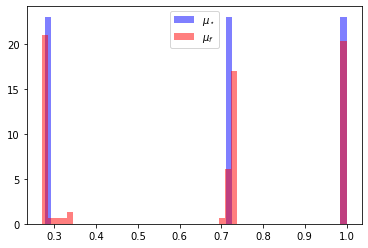

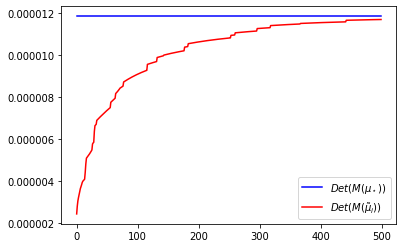

In [59]:
plt.hist(mu_star, bins = 50, density=True, Alpha = 0.5, label =r"$\mu_\star$", color ="blue")
plt.hist(rofstd, bins = 50, density=True, Alpha = 0.5, label =r"$\mu_f$", color ="red")
plt.legend()
plt.show()
plt.plot(np.arange(nt), (opt + 0 * np.arange(nt)), label = r"$Det(M(\mu_\star))$", color ="blue")
plt.plot(np.arange(nt), (val_liststd), label= r"$Det(M(\tilde{\mu}_i))$", color="red")
plt.legend()
plt.show()

It is clear that even though iterations of this algorithm are much costlier (we have 500 iterations/seconde when we had 9000 iterations/seconde). The convergence is much faster than that of SAGF algorithm.
We will see that this will not always be the case, but combining these methods gives better results than that of each one alone.

As we can guess knowing the general equivalence theorem, it is interesting to sample particles from a law of density $d(x,\mu)$ (proportional). This resembles Fedorov exchange Algorithm: Particles with higher generalized variance multiply when other with less variance die. 

## Dependence of BD algorithm upon $\alpha$

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 410.99it/s]


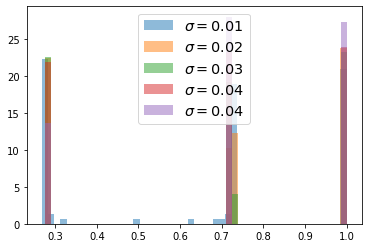

In [46]:
np.random.seed(0)
nt = 500
h= 0.01
sigma1 = lambda x : 0.0
alpha = lambda x : 0.1 
ro = np.linspace(0,1,101)
rofalpha1, val_listalpha1 = flow(ro, f, df, h, nt, sigma=sigma1, alpha=alpha)
plt.hist(rofalpha1, bins=50, density=True, alpha = 0.5, label = r"$\sigma =0.01$") 

nt = 500
h= 0.01
sigma2 = lambda x : 0.0
alpha = lambda x : 1
ro = np.linspace(0,1,101)
rofalpha2, val_listalpha2 = flow(ro, f, df, h, nt, sigma=sigma2, alpha=alpha)
plt.hist(rofalpha2, bins=50, density=True, alpha = 0.5, label = r"$\sigma =0.02$") 

nt = 500
h= 0.01
sigma3 = lambda x : 0.0
alpha = lambda x : 10
ro = np.linspace(0,1,101)
rofalpha3, val_listalpha3 = flow(ro, f, df, h, nt, sigma=sigma, alpha=alpha)
plt.hist(rofalpha3, bins=50, density=True, alpha = 0.5, label = r"$\sigma =0.03$") 

nt = 500
h= 0.01
sigma4 = lambda x :0.0
alpha = lambda x : 50
ro = np.linspace(0,1,101)
rofalpha4, val_listalpha4 = flow(ro, f, df, h, nt, sigma=sigma4, alpha=alpha)
plt.hist(rofalpha4, bins=50, density=True, alpha = 0.5, label = r"$\sigma =0.04$") 
plt.legend(fontsize ='x-large')

nt = 500
h= 0.01
sigma4 = lambda x :0.0
alpha = lambda x : 100
ro = np.linspace(0,1,101)
rofalpha5, val_listalpha5 = flow(ro, f, df, h, nt, sigma=sigma4, alpha=alpha)
plt.hist(rofalpha5, bins=50, density=True, alpha = 0.5, label = r"$\sigma =0.04$") 
plt.legend(fontsize ='x-large')

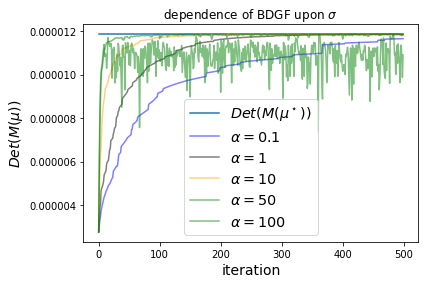

In [47]:
plt.plot(np.arange(nt), (opt + 0 * np.arange(nt)), label = r"$Det(M(\mu^\star))$")
plt.plot(np.arange(nt), (val_listalpha1), alpha =0.5,label= r"$\alpha =0.1$",color='blue')
plt.plot(np.arange(nt), (val_listalpha2), alpha =0.5,label= r"$\alpha =1$",color='black')
plt.plot(np.arange(nt), (val_listalpha3), alpha =0.5,label= r"$\alpha =10$",color='orange')
plt.plot(np.arange(nt), (val_listalpha4), alpha =0.5,label= r"$\alpha =50$",color='green')
plt.plot(np.arange(nt), (val_listalpha5), alpha =0.5,label= r"$\alpha =100$",color='green')

plt.legend(fontsize="x-large")
plt.xlabel("iteration",fontsize =14)
plt.ylabel(r"$Det(M(\mu))$", fontsize=14)
plt.title(r"dependence of BDGF upon $\sigma$")
plt.show()

As for SAGF, the convergence here too depends on a parameter $\alpha$. Analogously, convergence gets better and better with $\alpha$ getting bigger up to a limit, where BD becomes too reckless as for noisyGF and $\alpha$.

## N-D testing

## Quadratic model

In [61]:
#### Quadratic n-dimensional model
n = 2
v = lambda x : np.array([x[:,i] for i in range(n)]+[x[:,i]*x[:,j] for i in range(n) for j in range(i,n)]).T

dv = lambda x : np.array([ [0*x[:,i]+(i == l) for l in range(n)] +[ (i == j)*((k!=i)*x[:,k] + (k==i)*2*x[:,i]) for j in range(n) for k in range(j,n)] for i in range(n)] ).transpose(2,0,1)


### Standard GF algorithm

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1683.72it/s]


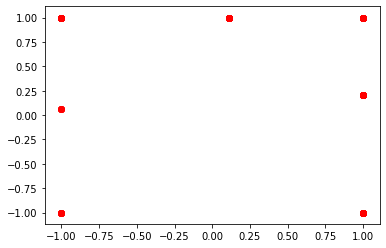

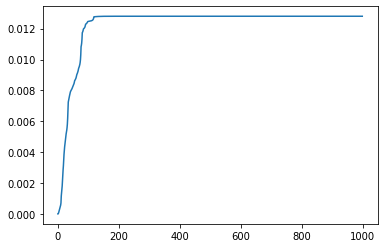

In [187]:
np.random.seed(0)
nt = 1000
h= 0.01
maxi = 1
mini = -1
sigma = lambda x : 0
alpha = lambda x : 0 
func = v
dfunc = dv
ro = rand.rand(200,n)
rofstd, val_liststd, imagea = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
plt.scatter(rofstd[:,0],rofstd[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_liststd)
plt.show()

In [75]:
Mv, invMv = Mromultiprim(rofstd, func)
vGopt = lambda x1,x2: np.trace(func(np.array([[x1,x2]])).dot(invMv).dot(func(np.array([[x1,x2]])).T))
delta = 1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2) for x1 in x for x2 in x]
k = n*(n+3)/2
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))

5.0
27.220255953275643
higher bound = 0.3860972787860158
lower bound = 0.011748247591598959


### NoisyGF

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1502.46it/s]


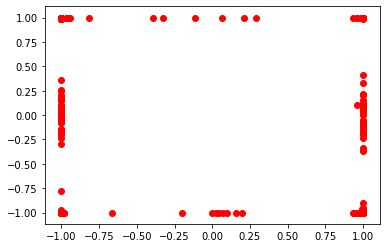

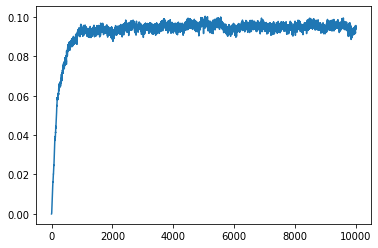

In [86]:
np.random.seed(0)
nt = 10000
h= 0.01
maxi = 1
mini = -1
sigma = lambda x : 0.3
alpha = lambda x : 0 
func = v
dfunc = dv
ro = rand.rand(200,n)
rofnoisy, val_listnoisy, imagea = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
plt.scatter(rofnoisy[:,0],rofnoisy[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_listnoisy)
plt.show()

In [90]:
Mv, invMv = Mromultiprim(rofstd, func)
vGopt = lambda x1,x2: np.trace(func(np.array([[x1,x2]])).dot(invMv).dot(func(np.array([[x1,x2]])).T))
delta = 0.1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2) for x1 in x for x2 in x]
k = n*(n+3)/2
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))

5.0
5.785704028606145
higher bound = 0.9876710742826454
lower bound = 0.8545837200686369


### Simulated Annealing GF (SAGF) Algorithm

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:31<00:00, 1601.73it/s]


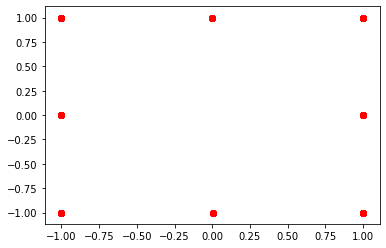

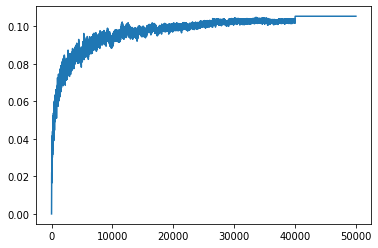

In [246]:
np.random.seed(0)
nt = 50000
h= 0.01
maxi = 1
mini = -1
sigma = lambda x : 3/(x+10)**0.25*(x<40000)
alpha = lambda x : 0 
func = v
dfunc = dv
ro = rand.rand(200,n)
rofSAGF, val_listSAGF, imagea = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
plt.scatter(rofSAGF[:,0],rofSAGF[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_listnoisy)
plt.show()

In [225]:
print("final value = "+str(val_listSAGF[-1]))

final value = 0.10540209716600984


In [147]:
Mv, invMv = Mromultiprim(rofSAGF, func)
vGopt = lambda x1,x2: np.trace(func(np.array([[x1,x2]])).dot(invMv).dot(func(np.array([[x1,x2]])).T))
delta = 0.1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2) for x1 in x for x2 in x]
k = n*(n+3)/2
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))

5.0
5.514956427680806
higher bound = 0.9942918565092458
lower bound = 0.9021348350686595


### Over-parametrization

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.22it/s]


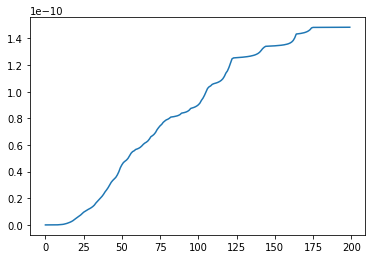

In [119]:
np.random.seed(0)
nt = 200
h= 0.01
maxi = 1
mini = -1
sigma = lambda x : 0
alpha = lambda x : 0 
func = v
dfunc = dv
ro = rand.rand(200,n)*(maxi-mini) -(maxi-mini)/2
rofstd, val_liststd, imagea = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
plt.plot(np.arange(nt), val_liststd)
plt.show()

In [122]:
hOP = 0.0001
niter = 100
sigmaW = lambda x : 0
ponderation = False
W, val_listOP,roprim = overparammultiprim(rofstd, func, niter, hOP, sigmaw = sigmaW, ponderation = ponderation)
plt.plot(val_listOP)
val_listOP[-1]

In [128]:
Mv = func(roprim).T.dot(W[:, np.newaxis] * func(roprim))
invMv = np.linalg.inv(Mv)
vGopt = lambda x1,x2: np.trace(func(np.array([[x1,x2]])).dot(invMv).dot(func(np.array([[x1,x2]])).T))
delta = 0.1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2) for x1 in x for x2 in x]
k = n*(n+3)/2
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))

IndexError: index 2 is out of bounds for axis 1 with size 2

<a list of 6 text.Text objects>

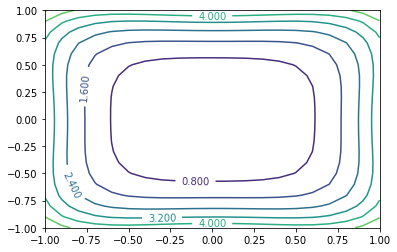

In [256]:
delta = 0.1
x = np.arange(-1.0, 1.0+delta, delta)
y = np.arange(-1.0, 1.0+delta, delta)
X, Y = np.meshgrid(x, y)
Z = [[vGopt(i,j) for i in x ] for j in y]
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)

In this case, unfortunately, over-parametrization does not converge to the extent it did for the cubic regression example, it does nonetheless reached a similar effeciency as SAGF. Combining both methods is interesting if we want to squeeze the most out of this.

### Birth-Death dynamic

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:38<00:00, 13.14it/s]


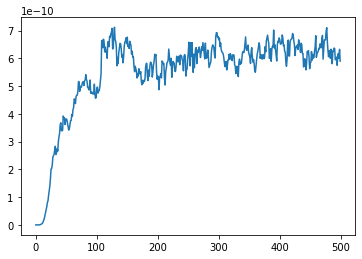

In [111]:
np.random.seed(0)
nt = 500
h= 0.01
maxi = 1
mini = -1
sigma = lambda x : 0 #3/(x+10)**0.25*(x<40000)
alpha = lambda x : 1 
func = v
dfunc = dv
ro = rand.rand(200,n)*(maxi-mini) -(maxi-mini)/2
rofBD, val_listBD, imagea = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
plt.plot(np.arange(nt), val_listBD)
plt.show()

In [282]:
print("final result = "+str(val_listBD[-1]))

final result = 0.11772667116627136


In [110]:
Mv = func(rofstd).T.dot(W[:, np.newaxis] * func(rofstd))
invMv = np.linalg.inv(Mv)
vGopt = lambda x1,x2: np.trace(func(np.array([[x1,x2]])).dot(invMv).dot(func(np.array([[x1,x2]])).T))
delta = 0.1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2) for x1 in x for x2 in x]
k = n*(n+3)/2
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))

ValueError: operands could not be broadcast together with shapes (7,1) (200,35) 

In [109]:
hOP = 0.0001
niter = 100
sigmaW = lambda x : 0
ponderation = False
W, val_listBDOP = overparammultiprim(rofBD, func, niter, hOP, sigmaw = sigmaW, ponderation = True)

NameError: name 'rofBD' is not defined

0.11777630885644336

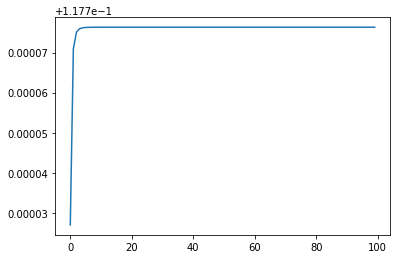

In [285]:
plt.plot(val_listBDOP)
val_listBDOP[-1]

In [286]:
Mv = func(rofBD).T.dot(W[:, np.newaxis] * func(rofBD))
invMv = np.linalg.inv(Mv)
vGopt = lambda x1,x2: np.trace(func(np.array([[x1,x2]])).dot(invMv).dot(func(np.array([[x1,x2]])).T))
delta = 0.1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2) for x1 in x for x2 in x]
k = n*(n+3)/2
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))

5.0
5.049468148924266
higher bound = 0.9999397209932526
lower bound = 0.9901551511642088


Combine all algorithm does show two things:
1. lower bound can be-as showed previously- far from the actual D-effeciency: when we get mild increases, we get large increases of the lower bound.
2. Combining all these approaches can interesting, in particular, combining over-parametrization and birth death dynamics gives similar results as simulated annealing while being faster (in iteration number)

### 7 Dimension quadratic model

In [4]:
#### Quadratic n-dimensional model
n = 7
v = lambda x : np.array([x[:,i] for i in range(n)]+[x[:,i]*x[:,j] for i in range(n) for j in range(i,n)]).T

dv = lambda x : np.array([ [0*x[:,i]+(i == l) for l in range(n)] +[ (i == j)*((k!=i)*x[:,k] + (k==i)*2*x[:,i]) for j in range(n) for k in range(j,n)] for i in range(n)] ).transpose(2,0,1)

### standard GF

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 136.34it/s]


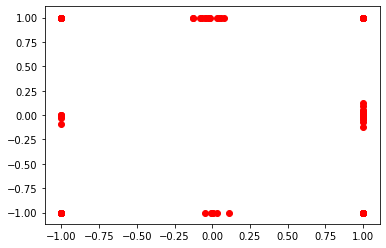

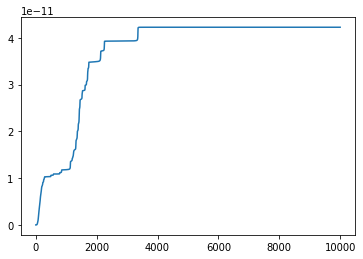

In [5]:
np.random.seed(0)
nt = 10000
h= 0.01
maxi = 1
mini = -1
sigma = lambda x : 0
alpha = lambda x : 0 
func = v
dfunc = dv
ro = rand.rand(200,n)
rofstd, val_liststd, imagea = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
plt.scatter(rofstd[:,0],rofstd[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_liststd)
plt.show()


In [162]:
Mv, invMv = Mromultiprim(rofstd, func)
vGopt = lambda x1,x2,x3,x4,x5,x6,x7: np.trace(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).dot(invMv).dot(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).T))
delta = 1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2,x3,x4,x5,x6,x7) for x1 in x for x2 in x for x3 in x for x4 in x for x5 in x for x6 in x for x7 in x]
k = n*(n+3)/2
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))


35.0
95.34876321178997
higher bound = 0.6872303339342041
lower bound = 0.17830666437826775


### Noisy GF

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [05:32<00:00, 150.31it/s]


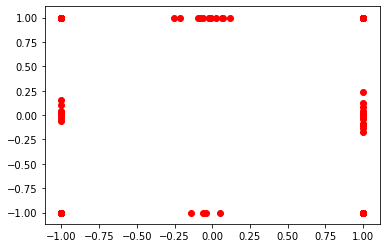

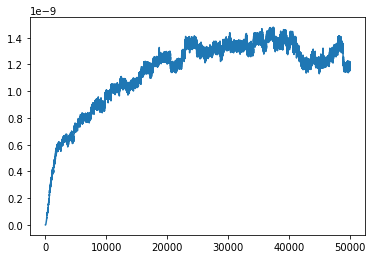

In [18]:
np.random.seed(0)
nt = 50000
h= 0.01
maxi = 1
mini = -1
sigma = lambda x : 0.22
alpha = lambda x : 0 
func = v
dfunc = dv
ro = rand.rand(200,n)
rofnoisy, val_listnoisy, imagea = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
plt.scatter(rofnoisy[:,0],rofnoisy[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_listnoisy)
plt.show()


In [19]:
Mv, invMv = Mromultiprim(rofnoisy, func)
vGopt = lambda x1,x2,x3,x4,x5,x6,x7: np.trace(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).dot(invMv).dot(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).T))
delta = 1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2,x3,x4,x5,x6,x7) for x1 in x for x2 in x for x3 in x for x4 in x for x5 in x for x6 in x for x7 in x]
k = n*(n+3)/2
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))

35.0
54.15852489664298
higher bound = 0.9188375698358565
lower bound = 0.5784596838482238


### SAGF

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:13<00:00, 75.12it/s]


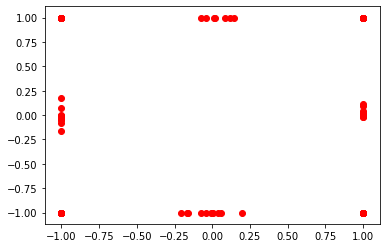

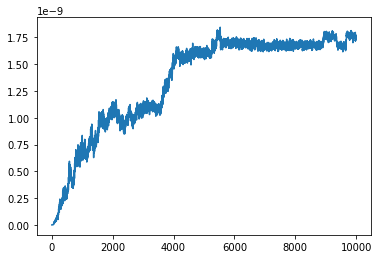

In [131]:
np.random.seed(0)
nt = 10000
h= 0.01
maxi = 1
mini = -1
sigma = lambda x : 2.2/(x+10)**(0.26*(x<40000))
alpha = lambda x : 0 
func = v
dfunc = dv
ro = rand.rand(200,n)
rofSAGF, val_listSAGF, imagea = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
plt.scatter(rofSAGF[:,0],rofSAGF[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_listSAGF)
plt.show()

In [132]:
print("final value = "+str(val_listSAGF[-1]))

final value = 1.735652467401198e-09


In [133]:
Mv, invMv = Mromultiprim(rofSAGF, func)
vGopt = lambda x1,x2,x3,x4,x5,x6,x7: np.trace(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).dot(invMv).dot(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).T))
delta = 1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2,x3,x4,x5,x6,x7) for x1 in x for x2 in x for x3 in x for x4 in x for x5 in x for x6 in x for x7 in x]
k = n*(n+3)/2
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))


35.0
50.40439807327937
higher bound = 0.9413129763343943
lower bound = 0.6439554970426886


### Over-parametrization

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.02it/s]


1.7769418329994706e-10


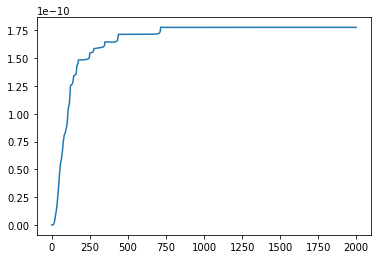

In [134]:
np.random.seed(0)
nt = 2000
h= 0.01
maxi = 1
mini = -1
sigma = lambda x : 0
alpha = lambda x : 0 
func = v
dfunc = dv
ro = rand.rand(200,n) *(maxi-mini) -(maxi-mini)/2
rofstd, val_liststd, imagea = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
plt.plot(np.arange(nt), val_liststd)
print(val_liststd[-1])
plt.show()


In [155]:
hOP = 0.0001
niter = 100
sigmaW = lambda x : 0
ponderation = False
W, val_listOP,roprim = overparammultiprim(rofstd, v, niter, hOP, sigmaw = sigmaW, ponderation = ponderation)


In [156]:
W

array([0.01015614, 0.00742932, 0.00874251, 0.0081716 , 0.0052927 ,
       0.01543176, 0.01261466, 0.01219734, 0.00952762, 0.00447313,
       0.01508692, 0.00420487, 0.00128726, 0.00313792, 0.00474112,
       0.00327884, 0.00384086, 0.00661889, 0.01209448, 0.00097706,
       0.00798618, 0.00875928, 0.00191455, 0.00292559, 0.00795074,
       0.01032221, 0.00877999, 0.01355913, 0.01241806, 0.00144768,
       0.01157459, 0.00726611, 0.00719841, 0.00114289, 0.01229341,
       0.00052065, 0.00131254, 0.00567643, 0.01081132, 0.00581564,
       0.00226767, 0.01515625, 0.00141648, 0.01193024, 0.00993331,
       0.00402497, 0.00757776, 0.00206516, 0.0077963 , 0.00948567,
       0.0107469 , 0.00888325, 0.01573331, 0.00605325, 0.0098067 ,
       0.0094925 , 0.01075828, 0.00397893, 0.00389481, 0.00364921,
       0.01083642, 0.01194989, 0.00808984, 0.00018702, 0.00793438,
       0.00065464, 0.00347439, 0.00420487, 0.01370322, 0.00684703,
       0.00733677, 0.01366399, 0.00769577, 0.00660493, 0.00833

1.0224730553889314e-08

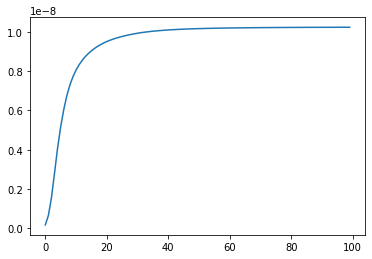

In [157]:
plt.plot(val_listOP)
val_listOP[-1]


In [158]:
Mv = func(roprim).T.dot(W[:, np.newaxis] * func(roprim))
invMv = np.linalg.inv(Mv)
vGopt = lambda x1,x2,x3,x4,x5,x6,x7: np.trace(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).dot(invMv).dot(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).T))
delta = 1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2,x3,x4,x5,x6,x7) for x1 in x for x2 in x for x3 in x for x4 in x for x5 in x for x6 in x for x7 in x]
k = n*(n+3)/2
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))

35.0
44.423959547767936
higher bound = 0.9734069118363196
lower bound = 0.7639476698829664


### Birth-Death dynamic

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:17<00:00, 25.65it/s]


ValueError: x and y can be no greater than 2-D, but have shapes (2000,) and (2000, 35, 35)

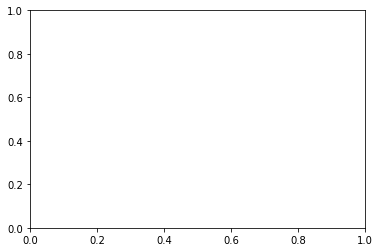

In [199]:
np.random.seed(0)
nt = 2000
h= 0.01
maxi = 1
mini = -1
sigma = lambda x : 0 #3/(x+10)**0.25*(x<40000)
alpha = lambda x : 0.02
func = v
dfunc = dv
ro = rand.rand(200,n)*(maxi-mini) -(maxi-mini)/2
rofBD, val_listBD, imagea = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
plt.plot(np.arange(nt), val_listBD)
plt.show()
print("final result = "+str(val_listBD[-1]))

In [177]:
Mv, invMv = Mromultiprim(rofBD, func)
vGopt = lambda x1,x2,x3,x4,x5,x6,x7: np.trace(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).dot(invMv).dot(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).T))
delta = 1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2,x3,x4,x5,x6,x7) for x1 in x for x2 in x for x3 in x for x4 in x for x5 in x for x6 in x for x7 in x]
k = n*(n+3)/2
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))


35.0
60.362509092470276
higher bound = 0.8803592031415373
lower bound = 0.4844974470423074


In [182]:
hOP = 0.0001
niter = 100
sigmaW = lambda x : 0
ponderation = False
W, val_listBDOP,roprim = overparammultiprim(rofBD, v, niter, hOP, sigmaw = sigmaW, ponderation = ponderation)


2.9255964322988788e-09

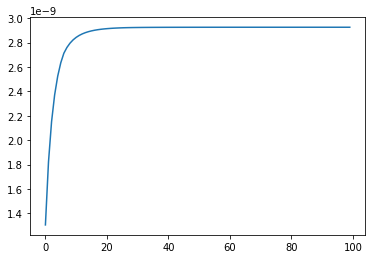

In [188]:
plt.plot(val_listBDOP)
val_listOP[-1]

In [191]:
Mv = func(roprim).T.dot(W[:, np.newaxis] * func(roprim))
invMv = np.linalg.inv(Mv)
vGopt = lambda x1,x2,x3,x4,x5,x6,x7: np.trace(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).dot(invMv).dot(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).T))
delta = 1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2,x3,x4,x5,x6,x7) for x1 in x for x2 in x for x3 in x for x4 in x for x5 in x for x6 in x for x7 in x]
k = n*(n+3)/2
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))

35.0
54.956249322414095
higher bound = 0.9139448456438477
lower bound = 0.5654244719765766


### Combination of the methods

100%|██████████████████████████████████████████████████████████████████████████████| 2200/2200 [01:24<00:00, 25.96it/s]


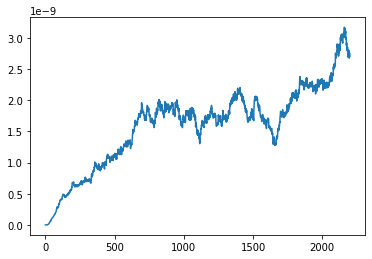

final result = 2.7010988745141015e-09


In [19]:
np.random.seed(0)
nt = 2200
h= 0.01
maxi = 1
mini = -1
sigma = lambda x : 0.22
alpha = lambda x : 0.02
func = v
dfunc = dv
ro = rand.rand(200,n)*(maxi-mini) -(maxi-mini)/2
rofcomb, val_listcomb, imagea = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
plt.plot(np.arange(nt), val_listcomb)
plt.show()
print("final result = "+str(val_listcomb[-1]))

In [20]:
hOP = 0.0001
niter = 100
sigmaW = lambda x : 0
ponderation = False
W, val_listcombOP,roprim = overparammultiprim(rofcomb, v, niter, hOP, sigmaw = sigmaW, ponderation = ponderation)

8.449282424717818e-09

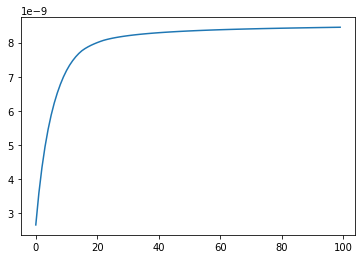

In [21]:
plt.plot(val_listcombOP)
val_listcombOP[-1]

In [23]:
Mv = func(roprim).T.dot(W[:, np.newaxis] * func(roprim))
invMv = np.linalg.inv(Mv)
vGopt = lambda x1,x2,x3,x4,x5,x6,x7: np.trace(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).dot(invMv).dot(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).T))
delta = 1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2,x3,x4,x5,x6,x7) for x1 in x for x2 in x for x3 in x for x4 in x for x5 in x for x6 in x for x7 in x]
k = n*(n+3)/2
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))

35.0
46.368678200827574
higher bound = 0.963699456093229
lower bound = 0.7226578703667622


# Fedorov Algorithm

In [190]:
g = lambda x: np.array([x[:,0], x[:,0]**2, x[:,1],x[:,1]**2]).T

dg = lambda x: np.array([[0*x[:,0]+1, 2*x[:,0],0*x[:,0],0*x[:,0]],[0*x[:,1], 0*x[:,1], 0*x[:,1]+1, 2*x[:,1]]]).transpose(2,0,1)

f = lambda x : np.array([x ,x**2, x**3]).T

df = lambda x : np.array([x*0+1, 2*x, 3*x**2])

def Mromultiprim(ro, g):
    n = ro.shape[0]
    M = g(ro).T.dot(g(ro))
    M = M/n
    invM = np.linalg.inv(M)
    return M, invM
    

def Mrofedorov(ro, f, w):
    M = f(ro).T.dot(np.diag(w).dot(f(ro)))
    invM = np.linalg.inv(M)
    return M, invM

### pour 1D pour le moment
def maxd(d, dim, mini, maxi, precision):
    x = np.linspace(mini, maxi, precision  +1)
    y = np.asarray([i for i in itertools.product(x,repeat = dim)])
    Z = np.asarray([d(np.asarray([i])) for i in y])
    M = np.amax(Z)
    return M, np.asarray(y[Z.argmax()])

###Fedorov
def Fedorov(ro, f, p, dim, epsilon, mini, maxi, itr, precision):
    rof = ro
    w = np.ones(ro.shape[0])/ro.shape[0]
    M, invM = Mrofedorov(ro,f,w)
    val = [np.linalg.det(M)]
    d = lambda x: f(x).dot(invM).dot(f(x).T)
    dbar, xi = maxd(d, dim, mini, maxi, precision)
    i = 0
    for i in tqdm(range(itr)):
        alpha = 1/(rof.size+1)
        rof = np.vstack((rof, xi))
        w = np.append((1-alpha)*w,alpha)
        dbar, xi = maxd(d, dim, mini, maxi, precision)
        M, invM = Mrofedorov(rof,f,w)
        d = lambda x: f(x).dot(invM).dot(f(x).T)
        val.append(np.linalg.det(M))
        if (dbar-p<epsilon):
            break
    return rof, val, w, i


In [60]:
nt = 50000
h= 0.01
sigma = lambda x :0.5/np.cbrt(x+10) # mettre sigma à 0 pour ne pas ajouter d'entropie
alpha = 0 # mettre à 0 pour ne pas ajouter de birth death
ro = np.linspace(0,1,101)
M, invM = Mro(ro,f)
rof, val_list = flow(ro, f, df, h, nt, sigma=lambda x:0., alpha=lambda x:0)
rofsig, val_listsig = flow(ro, f, df, h, nt, sigma=sigma, alpha=lambda x:0)


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:06<00:00, 7424.85it/s]


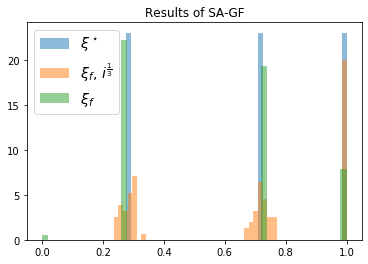

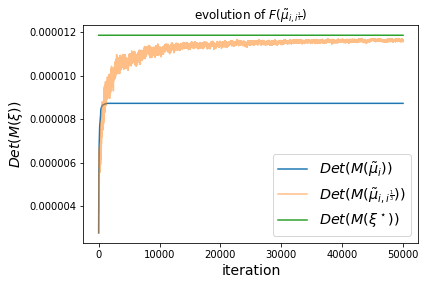

In [61]:
#plt.hist(ro, bins =25, density=True, alpha =0.5, label = r"$Unif[0,1]$")
plt.hist(mu_star, bins=50, density=True, alpha = 0.5, label = r"$\xi^\star$") 
plt.hist(rofsig, bins=50, density=True, alpha = 0.5, label = r"$\xi_f$, $i^\frac{1}{3}$") 
plt.hist(rof, bins=50, density=True, alpha = 0.5, label = r"$\xi_f$") 
plt.title("Results of SA-GF")
plt.legend(fontsize="x-large")
plt.show()
plt.plot(np.arange(nt), (val_list), label= r"$Det(M(\tilde{\mu}_i))$")
plt.plot(np.arange(nt), (val_listsig), alpha =0.5,label= r"$Det(M(\tilde{\mu}_{i,i^\frac{1}{3}}))$")
plt.plot(np.arange(nt), (opt + 0 * np.arange(nt)), label = r"$Det(M(\xi^\star))$")
plt.title(r"evolution of $F(\tilde{\mu}_{i,i^\frac{1}{3}})$")
plt.xlabel("iteration",fontsize =14)
plt.ylabel(r"$Det(M(\xi))$", fontsize=14)
plt.legend(fontsize="x-large")
plt.show()

In [256]:
(val_listsig[-1]/opt)**(1/3)

0.9974735909707678

3.3144771729404283


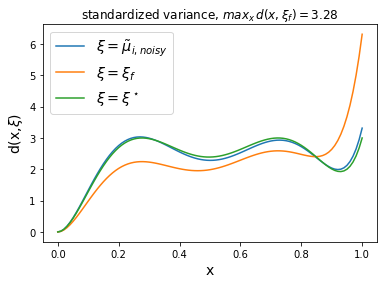

In [231]:
Mf,invMf = Mro(rofsig, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\xi = \tilde{\mu}_{i,noisy}$")
plt.title (r'standardized variance, $max_x\, d(x,\xi_f) = 3.28$')
print (dfopt[-1])
Mf,invMf = Mro(rof, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\xi = \xi_f$")
Mf,invMf = Mro(ro_star, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\xi = \xi^\star$")
plt.xlabel ('x', fontsize = 14)
plt.ylabel (r'd(x,$\xi$)',fontsize = 14)
plt.legend(fontsize ='x-large')
plt.show()

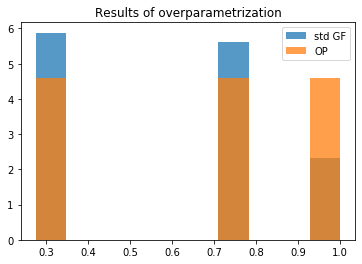

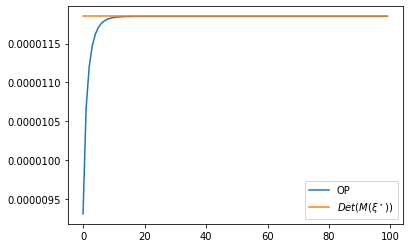

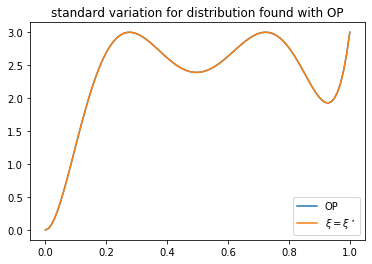

In [61]:
ro = np.linspace(0,1,101)

niter = 100
hop = 0.001
w , valomega = overparam(rof, f, niter, hop)
sigmaW = lambda x: 0
plt.hist(rof, bins=10, density=True,alpha =0.75, label= "std GF")
plt.hist(rof, bins=10, density=True, weights = w,alpha =0.75, label = "OP")
plt.title("Results of overparametrization")
plt.legend()
plt.show()
plt.plot(valomega, label = "OP")
plt.plot(np.arange(niter), (opt + 0 * np.arange(niter)), label = r"$Det(M(\xi^\star))$")
plt.legend()
#plt.title("Evolution throught gradient over weights")
plt.show()
M = f(rof).T.dot(w[:, np.newaxis] * f(rof))
invM = np.linalg.inv(M)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invM).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label ="OP")
Mf,invMf = Mro(ro_star, f)
fGopt = lambda x: np.trace(f(x)[np.newaxis,:].dot(invMf).dot(f(x)[:,np.newaxis]))
dfopt = [fGopt(x) for x in ro]
plt.plot (ro,dfopt, label =r"$\xi = \xi^\star$")
plt.title("standard variation for distribution found with OP")
plt.legend()
plt.show()

In [44]:
j=1
xi = f(ro)[j][np.newaxis,:]
M = f(ro).T.dot(w[:, np.newaxis] * f(ro))
(xi).dot(invM).dot(xi.T)[0,0]

0.0024068903700952605

In [220]:
### G
g = lambda x: np.array([x[:,0], x[:,0]**2, x[:,1],x[:,1]**2]).T

dg = lambda x: np.array([[0*x[:,0]+1, 2*x[:,0],0*x[:,0],0*x[:,0]],[0*x[:,1], 0*x[:,1], 0*x[:,1]+1, 2*x[:,1]]]).transpose(2,0,1)
ro = rand.rand(500,2)
Mg, invMg = Mromultiprim(ro, g)
gGopt = lambda x,y: np.trace(g(np.array([[x,y]])).dot(invMg).dot(g(np.array([[x,y]])).T))

<a list of 7 text.Text objects>

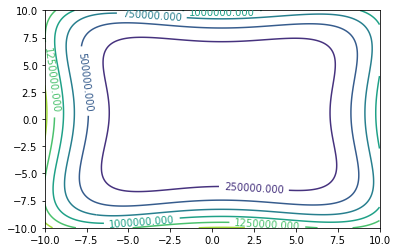

In [221]:
delta = 0.1
x = np.arange(-10.0, 10.0+delta, delta)
y = np.arange(-10.0, 10.0+delta, delta)
X, Y = np.meshgrid(x, y)
Z = [[gGopt(i,j) for i in x ] for j in y]
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 367.31it/s]


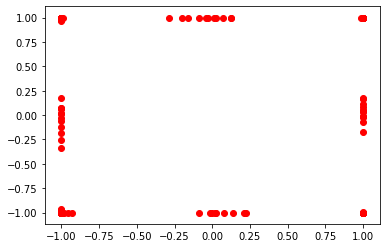

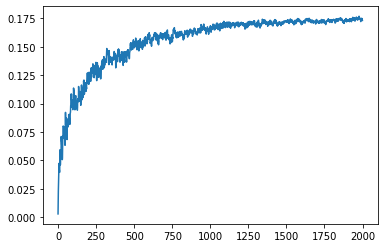

In [230]:
np.random.seed(0)
nt = 2000
h= 0.01
maxi = 1
mini = -1
sigma = lambda x: 5/(x+10)**0.43 # mettre sigma à 0 pour ne pas ajouter d'entropie
alpha = lambda x:0 # mettre à 0 pour ne pas ajouter de birth death
func = g
dfunc = dg
ro = (maxi-mini)*rand.rand(100,2) - (maxi-mini)/2
#plt.scatter(ro [:,0],ro [:,1], c = 'red')
plt.show()
M, invM= Mromultiprim(ro,g)
rof, val_list, imageg = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
#plt.hist(rof, bins=10, density=True)
#plt.show()

plt.scatter(rof[:,0],rof[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_list)
#plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

4.206398551640147

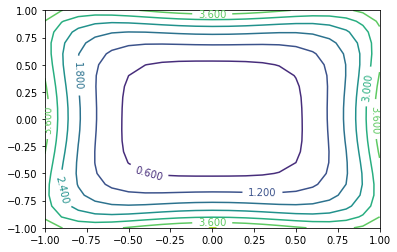

In [231]:
Mg, invMg = Mromultiprim(rof, g)
gGopt = lambda x,y: np.trace(g(np.array([[x,y]])).dot(invMg).dot(g(np.array([[x,y]])).T))
delta = 0.1
x = np.arange(-1.0, 1.0+delta, delta)
y = np.arange(-1.0, 1.0+delta, delta)
X, Y = np.meshgrid(x, y)
Z = [[gGopt(i,j) for i in x ] for j in y]
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
np.amax(Z)

In [232]:
np.exp(-(np.amax(Z)-4)/4)

0.9497090182261045

#### $\sigma = 0$, $ h= 0.0002 $, 50000 pas, 100 particules
resultat très bon avec h = 0.01, n = 2000000, sigma = 1 decroit en 1/np.cbrt(i+10)

In [212]:
val_list[-1]/opt

0.7358626265528486

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:23<00:00, 22.56it/s]


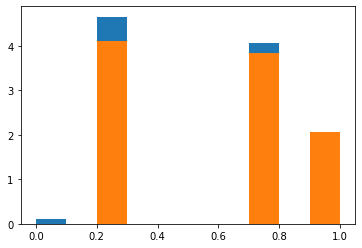

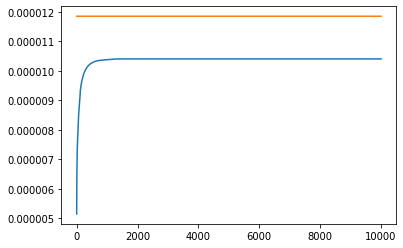

In [29]:
ro = np.linspace(0,1,101)
def overparam(ro, f, niter, h, w = 0*ro +1/ro.size , sigmaw = lambda x: 0):
    n = ro.size
    val_list=[]
    for i in range(niter):
        M = f(ro).T.dot(w[:, np.newaxis] * f(ro))
        invM = np.linalg.inv(M)
        for j in range (n):
            xi = f(ro)[j][np.newaxis,:]
            w[j] = w[j] + h * np.trace(xi.dot(invM).dot(xi.T)) + sigmaw(i) * 2 * np.sqrt(h) * rand.normal()
        w = w / np.sum(w)
        val_list.append(np.linalg.det(M))
    return w, val_list
def flowoverparam(ro0, f, df, h, nt,mini = 0, maxi =1, sigma = lambda x :0, alpha = 0, niter = 20, hop = 0.001):
    ro = ro0
    n = ro.shape[0]
    shape = ro.shape
    val_list = []
    w = 0*ro +1/n
    if (alpha == 0):
        for i in tqdm(range(nt)):
            w, valeur = overparam(ro, f, niter, hop, w = w)
            M = f(ro).T.dot(w[:, np.newaxis] * f(ro))
            invM = np.linalg.inv(M)
            V = Vt(f, df, invM)
            ro = euler(ro, V, h, sigma(i))
            ro = np.reshape(np.clip( ro.flatten(), mini, maxi), shape)
            val_list.append(np.linalg.det(M))
    else:  
        ####
        # Partie à regardé. Algorithme 1 Dans Bruna, Page 10, 
        # V = -f(x) M(\mu)^{-1} f(x)^t 
        # Vtilde = V - Vexp
        # f(x) = (x, x**2, x**3)
        ####
        for i in tqdm(range(nt)):
            val, invM = Mro(ro,f)
            V = Vt(f, df, invM)
            ro = euler(ro, V, h, sigma)
            ro = np.reshape(np.clip( ro.flatten(), mini, maxi), shape)
            Vbar = Vexp(ro, invM, f, sigma)
            # Debut Birth-Death
            for i in range(n):
                Vtilde = - f(ro[i]).dot(invM).dot(f(ro[i]).T) + sigma * (np.log(ro[i]) + 1 ) -Vbar
                if ((Vtilde>0)and(rand.uniform()<1-np.exp(Vtilde*h))): #Death
                    ro = np.delete(ro,i)
                if ((Vtilde<0) and (rand.uniform()<1 - np.exp(-Vtilde*h))): # Birth
                    ro = np.append(ro, ro[i])
            n1 = ro.shape[0]
            if (n1>n): #Boucle pour garder un nombre de particule constant
                for i in range(n1-n):
                    k = np.floor(rand.uniform()*ro.shape[0])
                    ro = np.delete(ro,k)
            if (n1<n):
                for i in range(n-n1):
                    k = np.floor(rand.uniform()*ro.shape[0])
                    ro = np.append(ro, 1-ro[k])
            # Fin Birth-Death
            val_list.append(val)
    return ro, val_list,w

nt = 10000
h= 0.01
sigma = lambda x : 0 # mettre sigma à 0 pour ne pas ajouter d'entropie
alpha = 0 # mettre à 0 pour ne pas ajouter de birth death
ro = np.linspace(0,1,101)
rof, val_list, w = flowoverparam(ro, f, df, h, nt, sigma=sigma, alpha=alpha)
plt.hist(rof, bins=10, density=True)
plt.hist(rof, bins=10, density=True, weights = w)
plt.show()
plt.show()
plt.plot(np.arange(nt), val_list)
plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

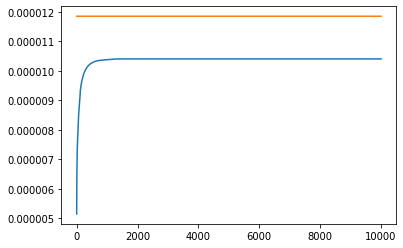

In [30]:
plt.plot(np.arange(nt), val_list)
plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

In [31]:
M = f(rof).T.dot(w[:, np.newaxis] * f(rof))

In [32]:
np.linalg.det(M)/opt


0.8779342440466158

100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [05:51<00:00, 569.49it/s]


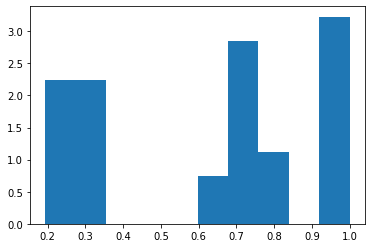

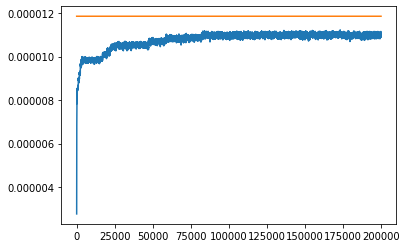

In [34]:
nt = 200000
h= 0.01
sigma = 0.02 # mettre sigma à 0 pour ne pas ajouter d'entropie
alpha = 0.1 # mettre à 0 pour ne pas ajouter de birth death
ro = np.linspace(0,1,100)
M, invM = Mro(ro,f)
rof1, val_list1 = flow(ro, f, df, h, nt, sigma = sigma, alpha = alpha)
plt.hist(rof1, bins=100, density=True)
plt.show()
#plt.plot(np.arange(nt), val_list)
plt.plot(np.arange(nt), val_list1)
plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

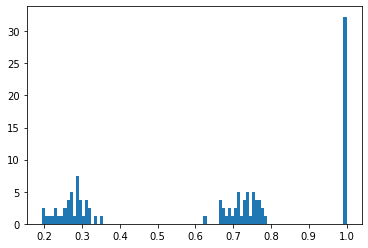

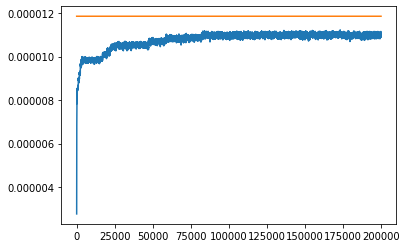

In [35]:
plt.hist(rof1, bins=100, density=True)
plt.show()
#plt.plot(np.arange(nt), val_list)
plt.plot(np.arange(nt), val_list1)
plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

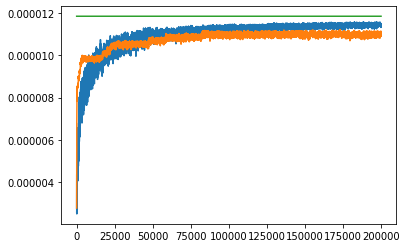

In [38]:
plt.plot(np.arange(nt), val_list)
plt.plot(np.arange(nt), val_list1)
plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

100%|████████████████████████████████████████████████████████████████████████| 400000/400000 [02:02<00:00, 3252.75it/s]


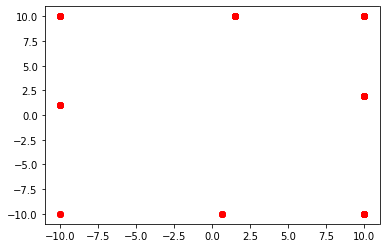

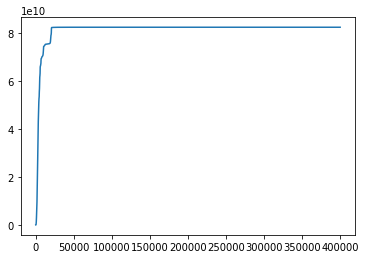

In [39]:
nt = 400000
h= 0.01
maxi = 10
mini = -10
sigma = lambda x: 0.0 # mettre sigma à 0 pour ne pas ajouter d'entropie
alpha = 0 # mettre à 0 pour ne pas ajouter de birth death
ro = rand.rand(100,2)
#plt.scatter(ro [:,0],ro [:,1], c = 'red')
plt.show()
M, invM = Mro(ro,g)
rof, val_list, imageg = flowmultiprim(ro, g, dg, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
#plt.hist(rof, bins=10, density=True)
#plt.show()

plt.scatter(rof[:,0],rof[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_list)
#plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

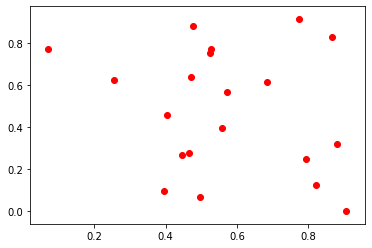

100%|██████████████████████████████████████████████████████████████████████| 4000000/4000000 [09:20<00:00, 7130.67it/s]


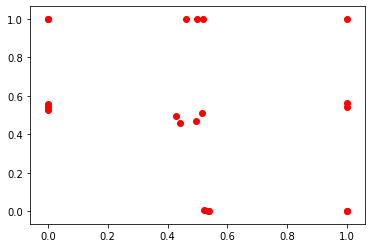

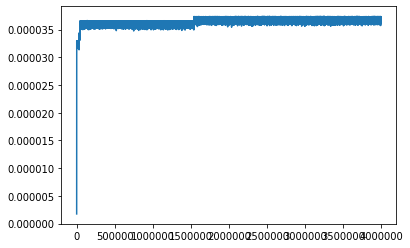

In [40]:
nt = 4000000
h= 0.001
maxi = 1
mini = 0
sigma = lambda x: 0.12 # mettre sigma à 0 pour ne pas ajouter d'entropie
alpha = 0 # mettre à 0 pour ne pas ajouter de birth death
ro = rand.rand(20,2)
plt.scatter(ro [:,0],ro [:,1], c = 'red')
plt.show()
M, invM = Mro(ro,g)
rof, val_list, imageg = flowmultiprim(ro, g, dg, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
#plt.hist(rof, bins=10, density=True)
plt.show()

plt.scatter(rof[:,0],rof[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_list)
#plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

In [150]:
##quad model

e = lambda x: np.array([x[:,0], x[:,0]**2, x[:,1],x[:,1]**2, x[:,0]*x[:,1]]).T

de = lambda x: np.array([[0*x[:,0]+1, 2*x[:,0],0*x[:,0],0*x[:,0], x[:,1]],[0*x[:,1], 0*x[:,1], 0*x[:,1]+1, 2*x[:,1], x[:,0]]]).transpose(2,0,1)



100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:59<00:00, 1674.65it/s]


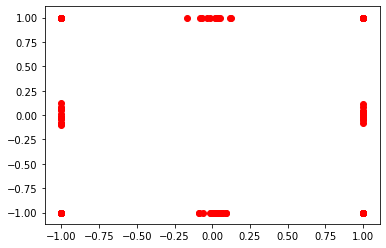

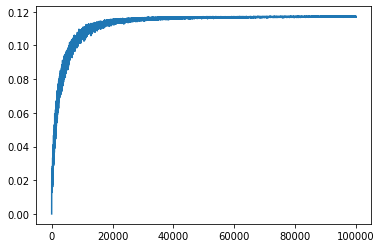

In [151]:
nt = 100000
h= 0.01
maxi = 1
mini = -1
sigma = lambda x: 20/(x+100)**0.45 # mettre sigma à 0 pour ne pas ajouter d'entropie
alpha = lambda x : 0*1 # mettre à 0 pour ne pas ajouter de birth death
func = e
dfunc = de
ro = rand.rand(200,2)
#plt.scatter(ro [:,0],ro [:,1], c = 'red')
plt.show()
rof, val_list, imagee = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
#plt.hist(rof, bins=10, density=True)
plt.show()

plt.scatter(rof[:,0],rof[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_list)
#plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()


In [152]:
val_list[-1]

0.11697816972432971

In [154]:
def overparammultiprim(ro, f, niter, h, sigmaw = lambda x: 0):
    n = ro.shape[0]
    w = np.ones(n)/n
    val_list=[]
    for i in range(niter):
        M = f(ro).T.dot(w[:, np.newaxis] * f(ro))
        invM = np.linalg.inv(M)
        offset = 0
        for j in range (n):
            xi = f(ro)[j][np.newaxis,:]
            offset = offset + (xi).dot(invM).dot(xi.T)[0,0]
            w[j] = w[j] + h * (xi).dot(invM).dot(xi.T) #+ sigmaw(i) * 2 * np.sqrt(h) * rand.normal()
        w = w/np.sum(w)#-h*offset/n
        val_list.append(np.linalg.det(M))
        if np.sum((w<0)*1)>0:
            return w , val_list, M
            break
    return w, val_list

niter = 100
hop = 0.001
w, valeop = overparammultiprim(rof, e, niter, hop)


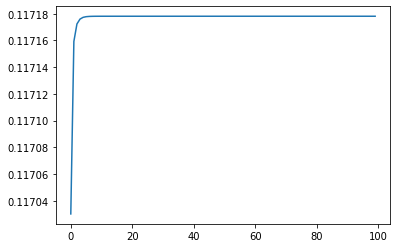

In [155]:
plt.plot(valeop)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:29<00:00, 1680.04it/s]


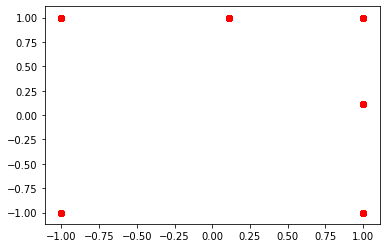

ValueError: x and y must have same first dimension, but have shapes (50000,) and (1000,)

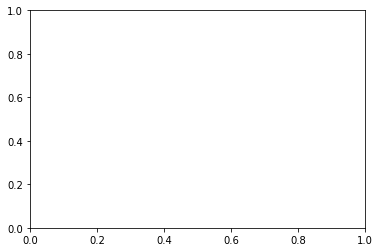

In [156]:
nt = 50000
h= 0.001
maxi = 1
mini = -1
sigma = lambda x: 0*20/(x+100)**0.45 # mettre sigma à 0 pour ne pas ajouter d'entropie
alpha = lambda x : 0*1 # mettre à 0 pour ne pas ajouter de birth death
func = e
dfunc = de
ro = rand.rand(200,2)
#plt.scatter(ro [:,0],ro [:,1], c = 'red')
plt.show()
rof0, val_list0, imagee0 = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
#plt.hist(rof, bins=10, density=True)
plt.show()

plt.scatter(rof[:,0],rof[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_list)
#plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

In [251]:
0.25**0.2

0.757858283255199

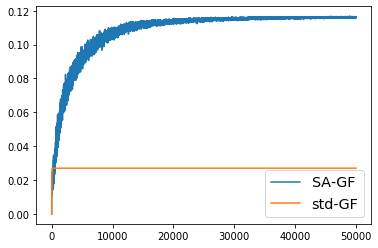

In [249]:
plt.plot(np.arange(nt), val_list, label=r"SA-GF")
plt.plot(np.arange(nt), val_list0, label = r"std-GF")
#plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.legend(fontsize="x-large")
plt.show()

0.9571326586609613

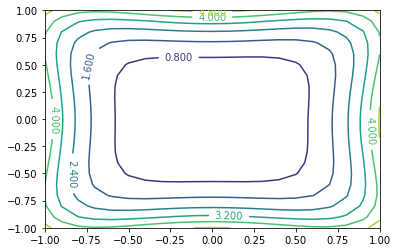

In [164]:
M = e(rof).T.dot(w[:, np.newaxis] * e(rof))
invMe = np.linalg.inv(M)
M,invMe = Mromultiprim(rof,e)
eGopt = lambda x,y: np.trace(e(np.array([[x,y]])).dot(invMe).dot(e(np.array([[x,y]])).T))
delta = 0.1
x = np.arange(-1.0, 1.0+delta, delta)
y = np.arange(-1.0, 1.0+delta, delta)
X, Y = np.meshgrid(x, y)
Z = [[eGopt(i,j) for i in x ] for j in y]
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
ZEmax=np.amax(Z)
np.exp(-(ZEmax-5)/5)

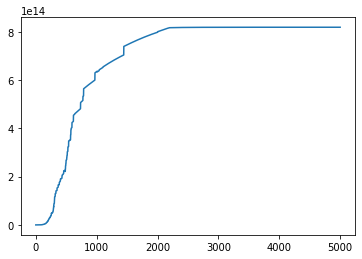

In [447]:
plt.plot(np.arange(nt), val_list)
#plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

<IPython.core.display.Javascript object>


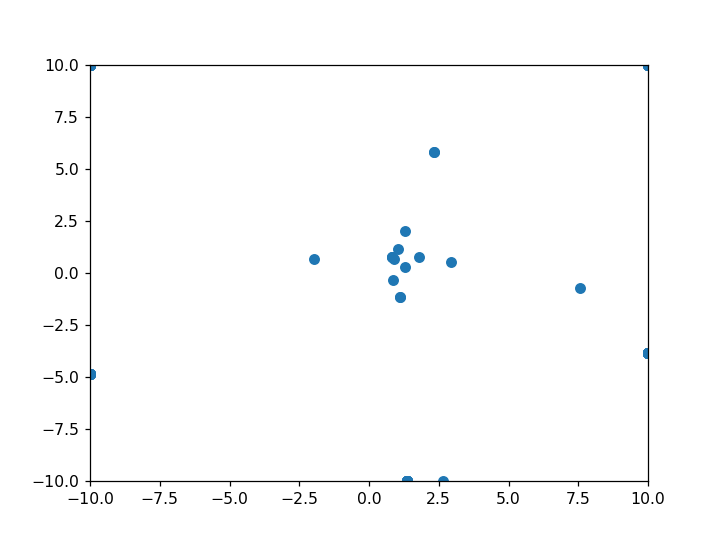

In [449]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.set(xlim=(-10,10),ylim=(-10,10))

xdata, ydata = [], []
ln, = plt.plot([], [])
scat = ax.scatter(imagee[0][:,0],imagee[0][:,1])
f = imagee
plt.figure(1)
#for i in range(20):
#    plt.scatter(f[10*i][:,0],f[10*i][:,1])
#    plt.pause(0.001)
    
#plt.show()
    
def init():
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ln.set_data(xdata,ydata)
    return ln,

def update(frame):
    scat.set_offsets(imagee[frame])

ani = FuncAnimation(fig, update, frames=2000, interval = 100,repeat=True)

plt.show()
#mywriter = FFMpegFileWriter(fps=25,codec="libx264")
#ani.save("test.mp4", writer=mywriter)

In [44]:
np.exp(-(np.amax(Z)-5)/5)

0.9146453837881345

In [14]:

a = lambda x: np.array([x[:,0], x[:,0]**2, x[:,1],x[:,1]**2, x[:,0]*x[:,1],x[:,2],x[:,2]**2,x[:,0]*x[:,2],x[:,2]*x[:,1]]).T

da = lambda x: np.array([[0*x[:,0]+1, 2*x[:,0],0*x[:,0],0*x[:,0], x[:,1],0*x[:,0],0*x[:,0],x[:,2],0*x[:,0]],[0*x[:,1], 0*x[:,1], 0*x[:,1]+1, 2*x[:,1], x[:,0],0*x[:,0],0*x[:,0],0*x[:,0],x[:,2]],[0*x[:,0],0*x[:,0],0*x[:,0],0*x[:,0],0*x[:,0],0*x[:,0]+1,2*x[:,2],x[:,0],x[:,1]]]).transpose(2,0,1)


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.35it/s]


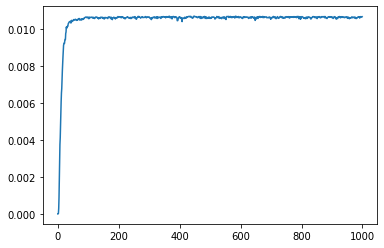

In [115]:
np.random.seed(0)
nt = 1000
h= 0.01
maxi = 1
mini = -1
sigma = lambda x: 10/(x+10) # mettre sigma à 0 pour ne pas ajouter d'entropie
alpha = 10 # mettre à 0 pour ne pas ajouter de birth death
func = a
dfunc = da
ro = rand.rand(200,3)
#plt.scatter(ro [:,0],ro [:,1], c = 'red')
rof, val_list, imagea = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
#plt.hist(rof, bins=10, density=True)
#plt.show()

#plt.scatter(rof[:,0],rof[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_list)
#plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

In [116]:
val_list[-1]

0.010652816562503204

In [117]:
Ma, invMa = Mromultiprim(rof, a)
aGopt = lambda x,y,z: np.trace(a(np.array([[x,y,z]])).dot(invMa).dot(a(np.array([[x,y,z]])).T))
delta = 1
x = np.arange(-1.0, 1.0+delta, delta)
y = np.arange(-1.0, 1.0+delta, delta)
X, Y = np.meshgrid(x, y)
Za = [[[aGopt(i,j,k) for i in x ] for j in x]for k in x]
np.amax(Za)

9.325424283259027

In [92]:
np.exp(-(np.amax(Za)-9)/9)

0.8325298284124755

In [4]:
e = lambda x: np.array([x[:,0], x[:,0]**2, x[:,1],x[:,1]**2, x[:,0]*x[:,1]]).T

de = lambda x: np.array([[0*x[:,0]+1, 2*x[:,0],0*x[:,0],0*x[:,0], x[:,1]],[0*x[:,1], 0*x[:,1], 0*x[:,1]+1, 2*x[:,1], x[:,0]]]).transpose(2,0,1)

### 10 D
n = 7
v = lambda x : np.array([x[:,i] for i in range(n)]+[x[:,i]*x[:,j] for i in range(n) for j in range(i,n)]).T

dv = lambda x : np.array([ [0*x[:,i]+(i == l) for l in range(n)] +[ (i == j)*((k!=i)*x[:,k] + (k==i)*2*x[:,i]) for j in range(n) for k in range(j,n)] for i in range(n)] ).transpose(2,0,1)


In [38]:
###Logistic regression
np.random.seed(0)
f = lambda x: np.array([1+x[:,0]*0,x[:,0],x[:,1],x[:,2],x[:,3],x[:,4],x[:,5],x[:,6],x[:,7],x[:,8],x[:,9],x[:,0]*x[:,8],x[:,1]*x[:,4],x[:,2]*x[:,3],x[:,5]*x[:,6],x[:,7]*x[:,9]]).T
df = lambda x: np.array([[ 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                         [ 1+0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                         [ 0*x[:,0], 1+0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                         [ 0*x[:,0], 0*x[:,0], 1+0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                        [ 0*x[:,0], 0*x[:,0], 0*x[:,0], 1+0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                        [ 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 1+0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                        [ 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 1+0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                         [ 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 1+0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                         [ 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 1+0*x[:,0], 0*x[:,0], 0*x[:,0]],
                         [ 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 1+0*x[:,0], 0*x[:,0]],
                        [ 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 1+0*x[:,0]],
                        [ 0*x[:,8], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], x[:,0], 0*x[:,0]],
                         [ 0*x[:,0], 0*x[:,4], 0*x[:,0], 0*x[:,0], x[:,1], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                         [ 0*x[:,0], 0*x[:,0], x[:,3], x[:,2], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                         [ 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], x[:,6], x[:,5], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                         [ 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], x[:,9], 0*x[:,0], x[:,7]]]).transpose(2,1,0)

ro = rand.rand(90,10)
#beta = np.array([[3,0.5,0.75,1.25,0.8,0.5,0.8,-0.4,-1,2.65,0.65,0.01,-0.02,0.03,-0.04,0.05]]).T
beta = np.ones([16,1])
eta = lambda x: beta.T.dot(f(x).T).T
deta = lambda x: (df(x)).dot(beta)
fhat = lambda x: np.sqrt(np.exp(eta(x))/((1+np.exp(eta(x)))**2))*f(x)
omega = lambda x : (np.exp(eta(x)) / ((1+np.exp(eta(x)))**2))
domega = lambda x : ((np.exp(eta(x))-np.exp(2*eta(x)))/(1+np.exp(2*eta(x)))**2)
Psi = lambda x : np.sqrt(omega(x))
DPsi = lambda x : np.asarray([(domega(np.array([y]))/(2*np.sqrt(omega(np.array([y]))))*deta(np.array([y])))[0] for y in x])
Dfhat = lambda x : np.asarray([ ((DPsi(np.array([y])))[0].dot(f(np.array([y]))) + Psi(np.array([y]))*df(np.array([y])))[0] for y in ro ])

In [39]:
f(ro).shape

(90, 16)

In [24]:
f = lambda x: np.array([1+x[:,0]*0,x[:,0],x[:,1],x[:,2],x[:,3],x[:,4],x[:,5],x[:,6]]).T
df = lambda x: np.array([[ 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                         [ 1+0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                         [ 0*x[:,0], 1+0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                         [ 0*x[:,0], 0*x[:,0], 1+0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                        [ 0*x[:,0], 0*x[:,0], 0*x[:,0], 1+0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0]],
                        [ 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 1+0*x[:,0], 0*x[:,0], 0*x[:,0]],
                        [ 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 1+0*x[:,0], 0*x[:,0]],
                         [ 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 0*x[:,0], 1+0*x[:,0]]]).transpose(2,1,0)

ro = rand.rand(90,7)
#beta = np.array([[3,0.5,0.75,1.25,0.8,0.5,0.8,-0.4,-1,2.65,0.65,0.01,-0.02,0.03,-0.04,0.05]]).T
beta = rand.rand(8,1)*2-1
eta = lambda x: beta.T.dot(f(x).T).T
deta = lambda x: (df(x)).dot(beta)
fhat = lambda x: np.sqrt(np.exp(eta(x))/((1+np.exp(eta(x)))**2))*f(x)
omega = lambda x : (np.exp(eta(x)) / ((1+np.exp(eta(x)))**2))
domega = lambda x : ((np.exp(eta(x))-np.exp(2*eta(x)))/(1+np.exp(2*eta(x)))**2)
Psi = lambda x : np.sqrt(omega(x))
DPsi = lambda x : np.asarray([(domega(np.array([y]))/(2*np.sqrt(omega(np.array([y]))))*deta(np.array([y])))[0] for y in x])
Dfhat = lambda x : np.asarray([ ((DPsi(np.array([y])))[0].dot(f(np.array([y]))) + Psi(np.array([y]))*df(np.array([y])))[0] for y in ro ])

100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [12:06:51<00:00,  2.18s/it]


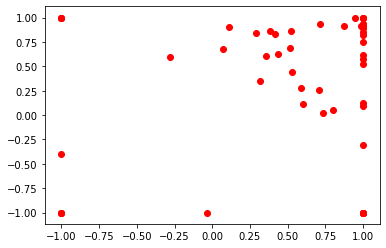

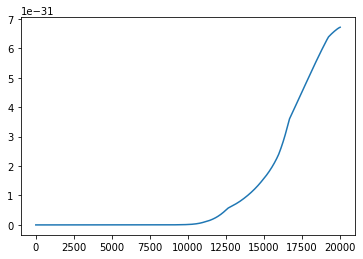

In [47]:
### x+10 ^ 0.2
## 25/(10+x)**(0.3+0.00005*x)
## Logistic regression
n = 10
np.random.seed(1)
nt = 20000
h= 0.0001
maxi = 1
mini = -1
sigma = lambda x: 0*5/(10+x)**0.75 # mettre sigma à 0 pour ne pas ajouter d'entropie
alpha = lambda x: 0*0.5   # mettre à 0 pour ne pas ajouter de birth death
func = fhat
dfunc = Dfhat
ro = rand.rand(50,n)
#plt.scatter(ro [:,0],ro [:,1], c = 'red')
plt.show()
rof, val_list, imagev = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
#plt.hist(rof, bins=10, density=True)
plt.show()

plt.scatter(rof[:,0],rof[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_list)
#plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

2.3539653394649433e-23

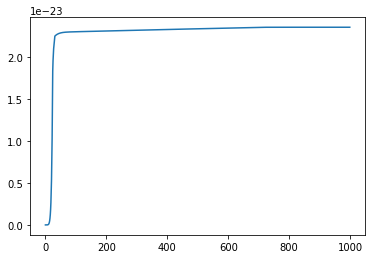

In [48]:
hOP = 0.0001
niter = 1000
sigmaW = lambda x : 0
ponderation = False
W, val_listOP,roprim = overparammultiprim(rof, func, niter, hOP, sigmaw = sigmaW, ponderation = ponderation)
plt.plot(val_listOP)
val_listOP[-1]

In [50]:
Mv = func(roprim).T.dot(W[:, np.newaxis] * func(roprim))
invMv = np.linalg.inv(Mv)
vGopt = lambda x1,x2,x3,x4,x5,x6,x7,x8,x9,x10: np.trace(func(np.array([[x1,x2,x3,x4,x5,x6,x7,x8,x9,x10]])).dot(invMv).dot(func(np.array([[x1,x2,x3,x4,x5,x6,x7,x8,x9,x10]])).T))
delta = 1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2,x3,x4,x5,x6,x7,x8,x9,x10) for x1 in x for x2 in x for x3 in x for x4 in x for x5 in x for x6 in x for x7 in x for x8 in x for x9 in x for x10 in x]
k = 16
Zmax = np.amax(Z)
print(k)
print(Zmax)
print("higher bound = " + str(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k))
print("lower bound = " + str(np.exp(-(np.amax(Z)-k)/k)))

16
8946.492077922254
higher bound = 0.004700779292719688
lower bound = 3.944896536293063e-243


In [33]:
Mv, invMv = Mromultiprim(rof, fhat)
fhatGopt = lambda x1,x2,x3,x4,x5,x6,x7: np.trace(fhat(np.array([[x1,x2,x3,x4,x5,x6,x7]])).dot(invMv).dot(fhat(np.array([[x1,x2,x3,x4,x5,x6,x7]])).T))
delta = 1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [fhatGopt(x1,x2,x3,x4,x5,x6,x7) for x1 in x for x2 in x for x3 in x for x4 in x for x5 in x for x6 in x for x7 in x]
k = 8
print(np.amax(Z))
np.exp(-(np.amax(Z)-k)/k)

19.565316725397906


0.23558945396250064

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:47<00:00, 62.68it/s]


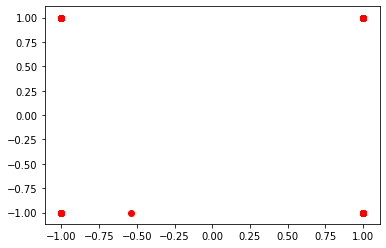

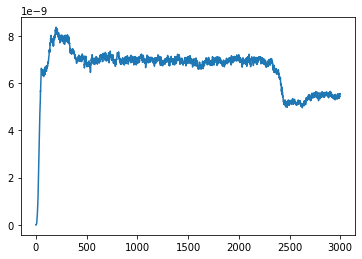

In [342]:
### x+10 ^ 0.2
## 25/(10+x)**(0.3+0.00005*x)
## Logistic regression
n = 7
np.random.seed(1)
nt = 3000
h= 0.01
maxi = 1
mini = -1
sigma = lambda x: 0.1 # mettre sigma à 0 pour ne pas ajouter d'entropie
alpha = lambda x: 0*0.2/(10*(1+x)/nt)  # mettre à 0 pour ne pas ajouter de birth death
func = fhat
dfunc = Dfhat
ro = rand.rand(50,n)
#plt.scatter(ro [:,0],ro [:,1], c = 'red')
plt.show()
rofsig, val_listsig, imagev = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
#plt.hist(rof, bins=10, density=True)
plt.show()

plt.scatter(rof[:,0],rof[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_listsig)
#plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

In [32]:
Mv, invMv = Mromultiprim(rofsig, func)
vGopt = lambda x1,x2,x3,x4,x5,x6,x7: np.trace(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).dot(invMv).dot(func(np.array([[x1,x2,x3,x4,x5,x6,x7]])).T))
delta = 1
x = np.arange(-1.0, 1.0+delta, delta)
Z = [vGopt(x1,x2,x3,x4,x5,x6,x7) for x1 in x for x2 in x for x3 in x for x4 in x for x5 in x for x6 in x for x7 in x]
k = 8
Zmax = np.amax(Z)
print(Zmax)
print(((Zmax - 1)/(k-1))**(k-1) * (k/Zmax)**k)
np.exp(-(np.amax(Z)-k)/k)

NameError: name 'rofsig' is not defined

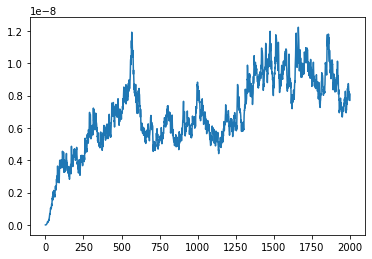

In [266]:
plt.plot(np.arange(nt), val_listsig)
#plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:14<00:00, 31.76it/s]


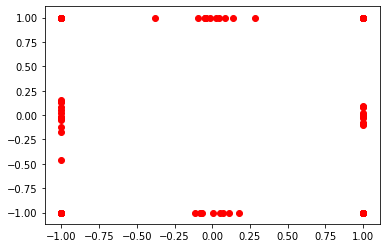

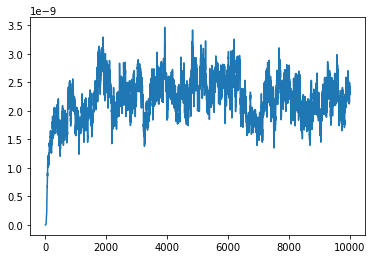

In [55]:
### x+10 ^ 0.2
## 25/(10+x)**(0.3+0.00005*x)
## Logistic regression
n = 7
np.random.seed(0)
nt = 10000
h= .01
maxi = 1
mini = -1
sigma = lambda x: 0.2+0*1/(1+x**.31+(x>10000)*((x-10000)/10000)**1) # mettre sigma à 0 pour ne pas ajouter d'entropie
alpha = lambda x: 0.51+0*1/(1+x)**0.5# mettre à 0 pour ne pas ajouter de birth death
func = v
dfunc = dv
ro = rand.rand(200,n)
#plt.scatter(ro [:,0],ro [:,1], c = 'red')
plt.show()
rof, val_list, imagev = flowmultiprim(ro, func, dfunc, h, nt,mini = mini, maxi = maxi, sigma = sigma, alpha = alpha)
#plt.hist(rof, bins=10, density=True)
plt.show()

plt.scatter(rof[:,0],rof[:,1], c= 'red')
plt.show()
plt.plot(np.arange(nt), val_list)
#plt.plot(np.arange(nt), opt + 0 * np.arange(nt))
plt.show()

In [28]:
g = lambda x: np.array([x[:,0], x[:,0]**2, x[:,1],x[:,1]**2]).T

dg = lambda x: np.array([[0*x[:,0]+1, 2*x[:,0],0*x[:,0],0*x[:,0]],[0*x[:,1], 0*x[:,1], 0*x[:,1]+1, 2*x[:,1]]]).transpose(2,0,1)

f = lambda x : np.array([x ,x**2, x**3]).T

df = lambda x : np.array([x*0+1, 2*x, 3*x**2])

def Mromultiprim(ro, g):
    n = ro.shape[0]
    M = g(ro).T.dot(g(ro))
    M = M/n
    invM = np.linalg.inv(M)
    return M, invM
    

def Mrofedorov(ro, f, w):
    M = f(ro).T.dot(np.diag(w).dot(f(ro)))
    invM = np.linalg.inv(M)
    return M, invM

### pour 1D pour le moment
def maxd(d, dim, mini, maxi, precision):
    x = np.linspace(mini, maxi, precision  +1)
    y = np.asarray([i for i in itertools.product(x,repeat = dim)])
    Z = np.asarray([d(np.asarray([i])) for i in y])
    M = np.amax(Z)
    return M, np.asarray(y[Z.argmax()])

###Fedorov
def Fedorov(ro, f, p, dim, epsilon, mini, maxi, itr, precision):
    rof = ro
    w = np.ones(ro.shape[0])/ro.shape[0]
    M, invM = Mrofedorov(ro,f,w)
    val = [np.linalg.det(M)]
    d = lambda x: f(x).dot(invM).dot(f(x).T)
    dbar, xi = maxd(d, dim, mini, maxi, precision)
    i = 0
    for i in tqdm(range(itr)):
        alpha = 1/(rof.size+1)
        rof = np.vstack((rof, xi))
        w = np.append((1-alpha)*w,alpha)
        dbar, xi = maxd(d, dim, mini, maxi, precision)
        M, invM = Mrofedorov(rof,f,w)
        d = lambda x: f(x).dot(invM).dot(f(x).T)
        val.append(np.linalg.det(M))
        if (dbar-p<epsilon):
            break
    return rof, val, w, i


In [29]:
M, invM  = Mrofedorov(ro,g,w)
M.shape

NameError: name 'w' is not defined

In [30]:
d = lambda x: f(x).T.dot(invM).dot(f(x))
x = np.linspace(0,1,101)
y = [u for u in itertools.product(x,repeat = 2)]
g(np.asarray([y[0]]))
np.asarray([y[0]])

array([[0., 0.]])

In [31]:
epsilon = 0.01
mini = -10.
itr = 1000
maxi = 10.
dim = 5
p = dim*(dim+3)/2
n = dim
v = lambda x : np.array([x[:,i] for i in range(n)]+[x[:,i]*x[:,j] for i in range(n) for j in range(i,n)]).T

dv = lambda x : np.array([ [0*x[:,i]+(i == l) for l in range(n)] +[ (i == j)*((k!=i)*x[:,k] + (k==i)*2*x[:,i]) for j in range(n) for k in range(j,n)] for i in range(n)] ).transpose(2,0,1)

precision = 10
ro = (maxi-mini)*rand.rand(int(p+1),int(dim))- (maxi - mini)/2
w = np.ones(ro.shape[0])/ro.shape[0]
rof_fedorov, val_list_fedorov, w, i = Fedorov(ro,v,p,dim,epsilon,mini,maxi,itr,precision)

  0%|                                                                               | 1/1000 [00:08<2:27:46,  8.88s/it]

KeyboardInterrupt: 

MemoryError: 

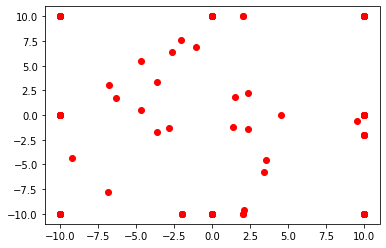

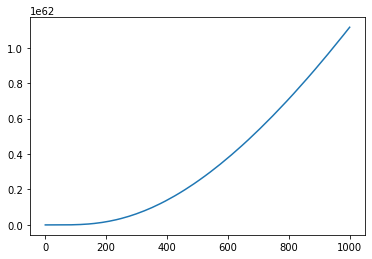

In [7]:
plt.scatter(rof_fedorov[:,0],rof_fedorov[:,1], c= 'red')
plt.figure()
plt.plot(val_list_fedorov)
precision = 100
M, invM  = Mrofedorov(rof_fedorov,v,w)
d = lambda x: v(x).dot(invM).dot(v(x).T)
dbar , xi = maxd(d,dim,mini,maxi,precision)
dbar

ValueError: weights should have the same shape as x

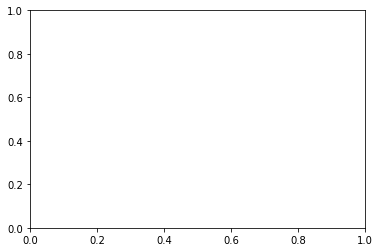

In [186]:
plt.hist(rof_fedorov, bins=10, density=True, weights = w)
plt.show()
#plt.plot(np.arange(nt), val_list)
plt.plot(np.arange(i+1), val_list_fedorov)
plt.plot(np.arange(i+1), opt + 0 * np.arange(i+1))
plt.show()

In [ ]:
###Logistic regression
f(x)